In [403]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, balanced_accuracy_score,
                           precision_recall_curve, average_precision_score, roc_curve)

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Сравнение моделей классификации на датасете "UCI_Credit_Card". 

### Датасет состоит из 30к наблюдений, разобьем его так, что 80% - train, 10% - validation, 10% - test. Данные нормализуем.
### В некоторых моделях для обучения будем использовать данные, которые прошли через PCA.
### Список моделей:
- Наивный Байесовский Классификатор
- KNN
- SVM
- Логистическая регрессия
- Случайный лес
- Градиентный бустинг (catboost)
- Stacking

In [404]:
DF = pd.read_csv("UCI_Credit_Card.csv")
DF.rename(columns = {'default.payment.next.month' : 'DefaultPayment'}, inplace = True)

# 1. Посмотрим на данные

In [405]:
DF.nunique()

ID                30000
LIMIT_BAL            81
SEX                   2
EDUCATION             7
MARRIAGE              4
AGE                  56
PAY_0                11
PAY_2                11
PAY_3                11
PAY_4                11
PAY_5                10
PAY_6                10
BILL_AMT1         22723
BILL_AMT2         22346
BILL_AMT3         22026
BILL_AMT4         21548
BILL_AMT5         21010
BILL_AMT6         20604
PAY_AMT1           7943
PAY_AMT2           7899
PAY_AMT3           7518
PAY_AMT4           6937
PAY_AMT5           6897
PAY_AMT6           6939
DefaultPayment        2
dtype: int64

In [406]:
DF.loc[DF['EDUCATION'] >= 6, 'EDUCATION'] = 5
DF.loc[DF['EDUCATION'] <= 0, 'EDUCATION'] = 5

DF.loc[DF['MARRIAGE'] >= 4, 'MARRIAGE'] = 3
DF.loc[DF['MARRIAGE'] <= 0, 'MARRIAGE'] = 3

In [407]:
DF.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  DefaultPayment  
0       0.0       0.0       0.0               1  
1    1000.0       0.0    2000.0               1  
2    1000.0    1000.0    5000.0               0  
3    1100.0    1069.0    1000.0               0  
4    9000.0     689.0     679.0               0  

[5 rows x 25 columns]

In [408]:
DF_nulls = round((DF.isna().sum()) / 30000, 3)
DF_nulls = DF_nulls[DF_nulls > 0]
print(DF_nulls)

Series([], dtype: float64)


### Нет пропусков!

In [409]:
DefaultPayment_true = len(DF['DefaultPayment'][DF['DefaultPayment'] == 1])
DefaultPayment_false = len(DF['DefaultPayment'][DF['DefaultPayment'] == 0])

print("Количество клиентов с дефолтом в следующем месяце:", DefaultPayment_true)
print("Количество клиентов без дефолта в следующем месяце:", DefaultPayment_false)

print()

print(f"Дисбаланс: всего {round(100 * DefaultPayment_true / (DefaultPayment_false + DefaultPayment_true))}% клиентов с дефолтом в следующем месяце")

Количество клиентов с дефолтом в следующем месяце: 6636
Количество клиентов без дефолта в следующем месяце: 23364

Дисбаланс: всего 22% клиентов с дефолтом в следующем месяце


In [410]:
DF.describe()

ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853767      1.557267   
std     8660.398374   129747.661567      0.489129      0.784391      0.521405   
min        1.000000    10000.000000      1.000000      1.000000      1.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      5.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802      1.197186      1.196868      1.169139   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  DefaultPayment  
count   30000.000000    30000.000000  
mean     5215.502567        0.221200  
std     17777.465775        0.415062  
min         0.000000        0.000000  
25%       117.750000        0.000000  
50%      1500.000000        0.000000  
75%      4000.000000        0.000000  
max    528666.000000        1.000000  

[8 rows x 25 columns]

In [411]:
DF_for_corr = DF.drop(columns = 'ID', axis = 1)
correlation_matrix = DF_for_corr.corr()

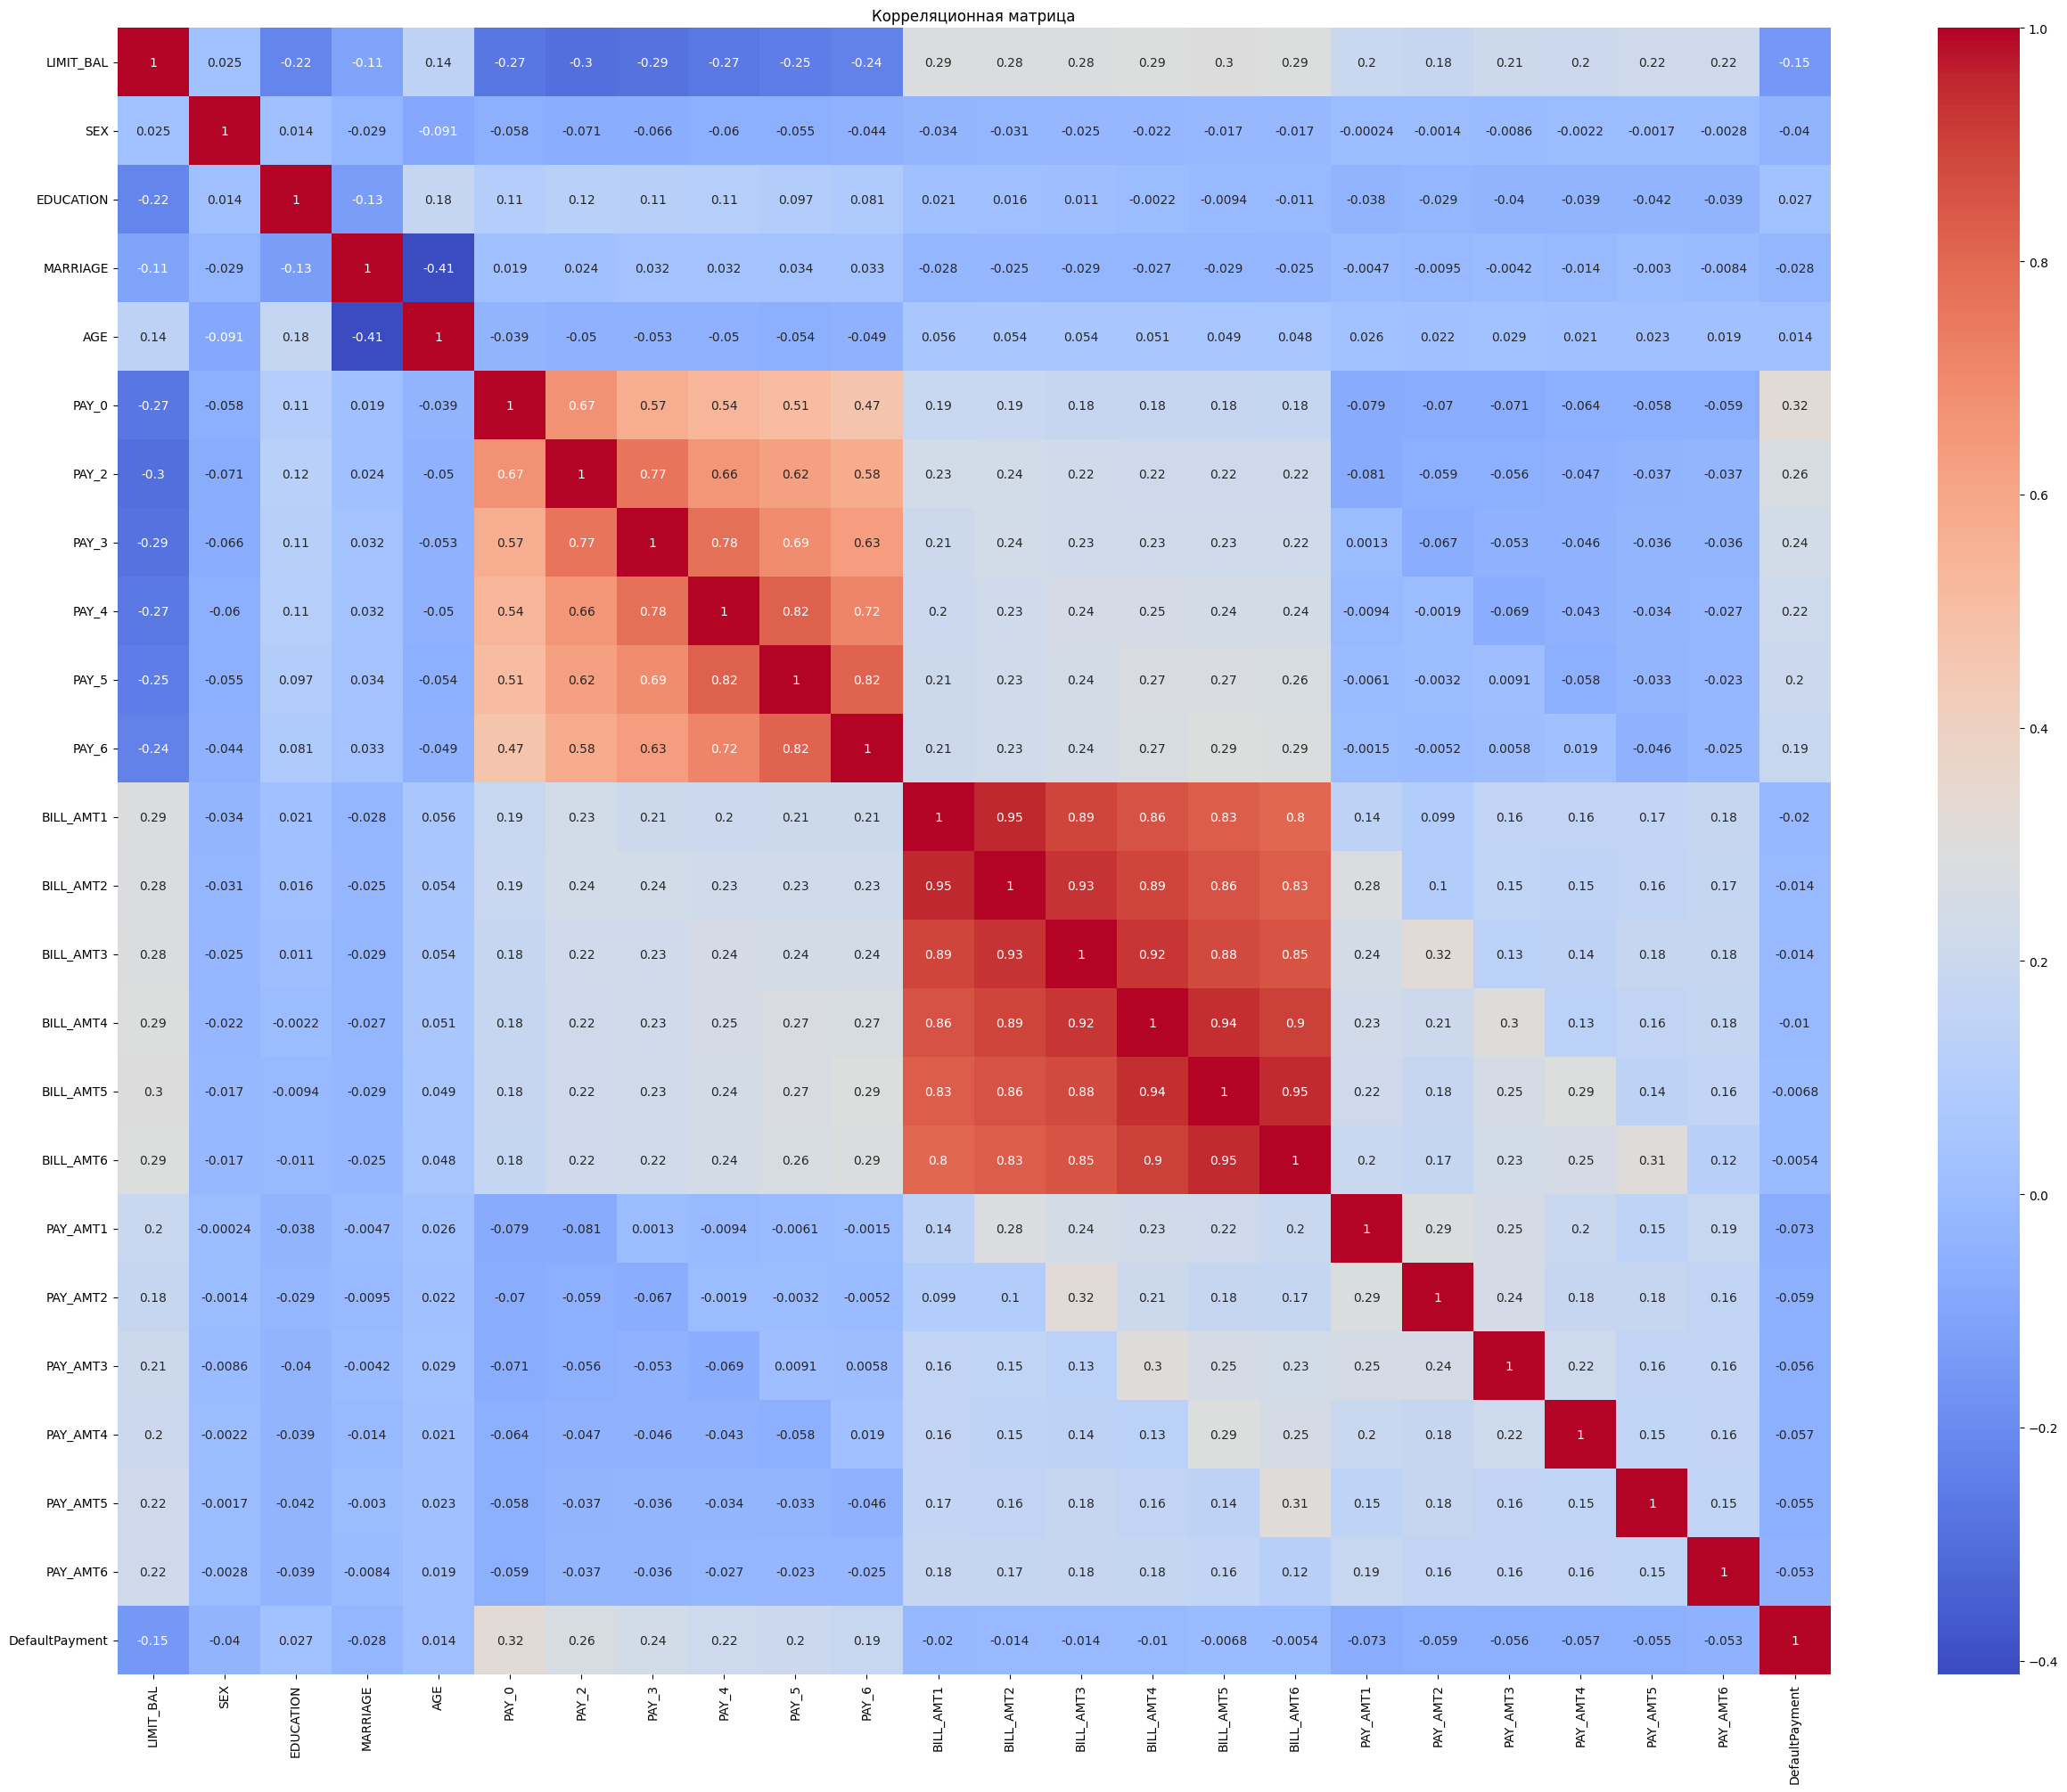

In [412]:
plt.figure(figsize=(31,24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

### Видим, что:
- С целевой переменной сильнее всего коррелируют переменные PAy (отвечающие за выплаты в указанные месяцы, 0 - сентября, 2 - август и так далее)
- Видна мультиколлинеарность в группах PAy и BILL, что ожидаемо
- Также видна ожидаемая корреляция между суммой, выданной в кредит и выплатами и счетами

\
Также интересное наблюдение, что заметна корреляция между возрастом и браком. К нашей задаче это не относится, но все же

In [413]:
def plot_boxplot(data, column):
    plt.figure(figsize = (10, 6))
    sns.boxplot(x = 'DefaultPayment', y = column, data = data)
    plt.title(f'Распределение {column} по статусу платежа')
    plt.grid()
    
    plt.show()

In [414]:
def plot_pie_chart(data, column, label_dict = None):
    fig, axis = plt.subplots(1, 2, figsize=(12, 6))
    
    data_default = data[data['DefaultPayment'] == 1]
    counts_default = data_default[column].value_counts()

    data_non_default = data[data['DefaultPayment'] == 0]
    counts_non_default = data_non_default[column].value_counts()

    if label_dict:
        labels_default = [label_dict.get(X, X) for X in counts_default.index]
        labels_non_default = [label_dict.get(X, X) for X in counts_non_default.index]
    else:
        labels_default = counts_default.index
        labels_non_default = counts_non_default.index
    
    axis[0].pie(counts_default, labels = labels_default, autopct = '%1.1f%%', startangle = 90)
    axis[0].set_title('Default (Проблемные клиенты)')
    
    axis[1].pie(counts_non_default, labels = labels_non_default, autopct = '%1.1f%%', startangle = 90)
    axis[1].set_title('Not Default (Хорошие клиенты)')
    
    plt.suptitle(f'Распределение по статусу платежа')
    plt.tight_layout()
    plt.show()

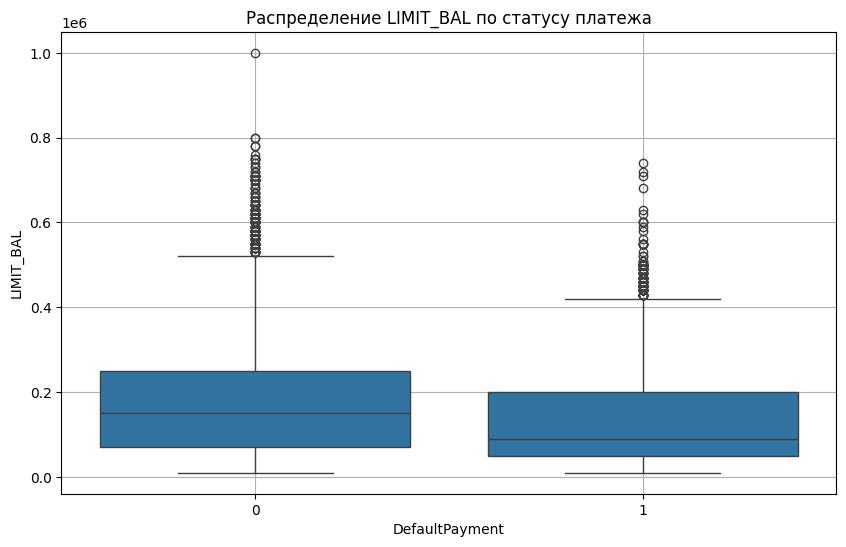

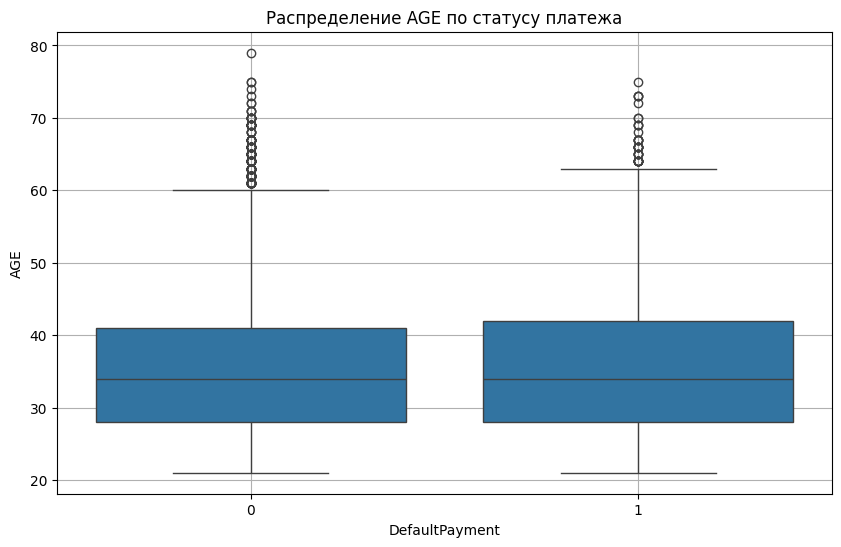

In [415]:
plot_boxplot(DF, 'LIMIT_BAL')
plot_boxplot(DF, 'AGE')

### Видим, что возраст особо не влияет, однако люди, которые занимали больше, чаще не выплачивали долг

In [416]:
DF_graphics = DF.copy()
DF_graphics.loc[DF['EDUCATION'] >= 4, 'EDUCATION'] = 4

labels_sex = {1: 'male', 2: 'female'}
labels_marriage = {1: 'married', 2: 'single', 3: 'others'}
labels_education = {1: 'graduate school', 2: 'university', 3: 'high school', 4: 'other'}

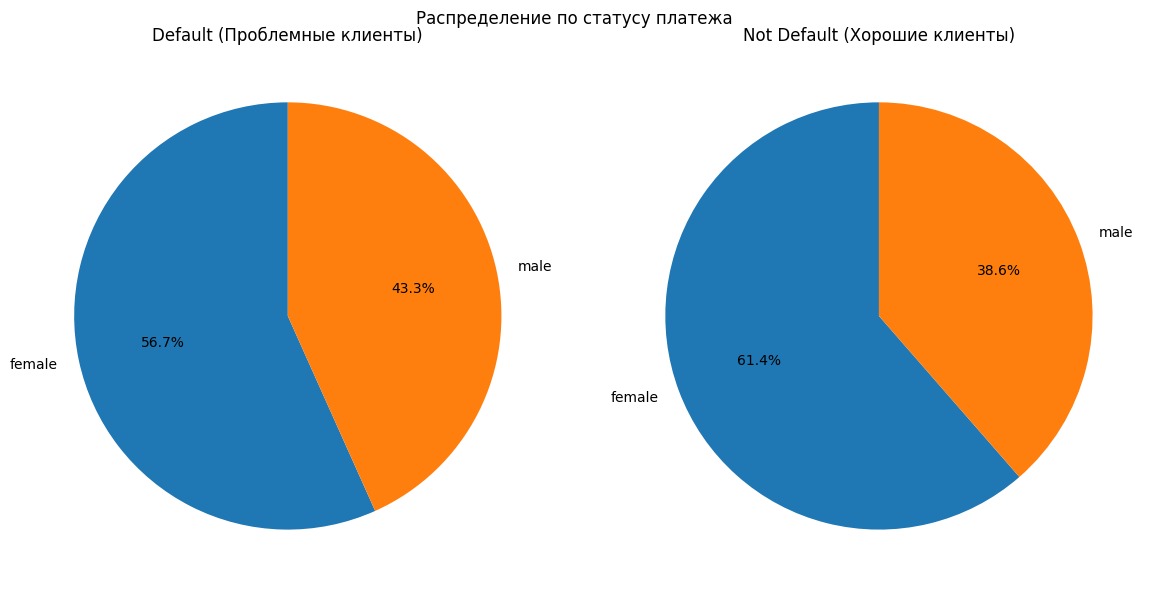

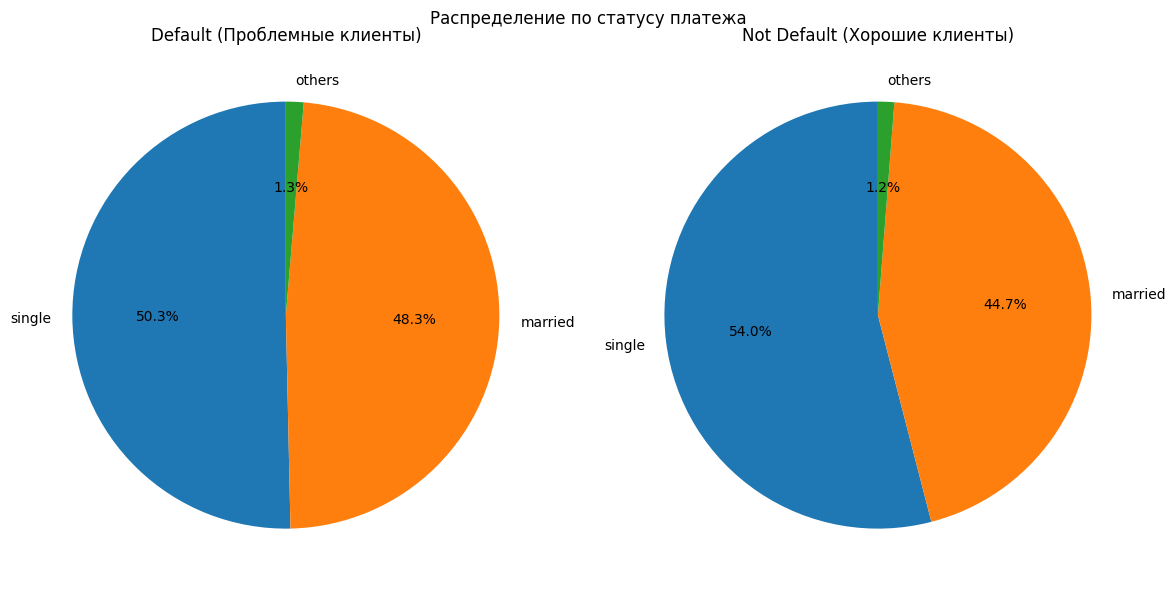

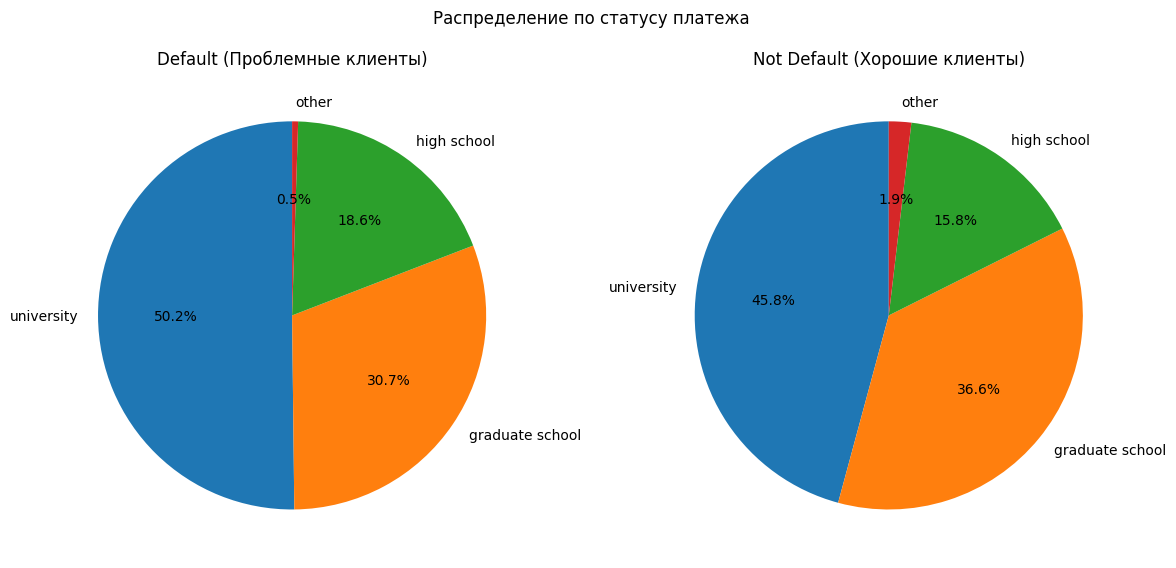

In [417]:
plot_pie_chart(DF_graphics, 'SEX', labels_sex)
plot_pie_chart(DF_graphics, 'MARRIAGE', labels_marriage)
plot_pie_chart(DF_graphics, 'EDUCATION', labels_education)

### По диаграммам видно, что:
- Женщины чуть реже становятся проблемными клиентами
- Люди не в браке чаще выплачивают долг
- Образование влияет на то, выплатит ли клиент долг

# 2. Разобьем выборку на train / validation / test и отнормируем данные

In [418]:
X = DF.drop(['ID', 'DefaultPayment'], axis=1)
y = DF['DefaultPayment']

X_pca = X.copy()
y_pca = y.copy()

In [419]:
cols = X.columns
    
X_cols = X[cols]

scaler = StandardScaler()
X_cols_scaled = scaler.fit_transform(X_cols)

for components in range(1, 23):
    pca_cols = PCA(n_components = components) 
    current = pca_cols.fit_transform(X_cols_scaled)
    print(f'Components: {components}, объясненная дисперсия (суммарно): {sum(pca_cols.explained_variance_ratio_)}')

Components: 1, объясненная дисперсия (суммарно): 0.28447895402092827
Components: 2, объясненная дисперсия (суммарно): 0.4626892015027863
Components: 3, объясненная дисперсия (суммарно): 0.5299749009353724
Components: 4, объясненная дисперсия (суммарно): 0.5938162166311111
Components: 5, объясненная дисперсия (суммарно): 0.6383490476928015
Components: 6, объясненная дисперсия (суммарно): 0.6801771871302188
Components: 7, объясненная дисперсия (суммарно): 0.7196234965751518
Components: 8, объясненная дисперсия (суммарно): 0.758219157145933
Components: 9, объясненная дисперсия (суммарно): 0.7960964640026871
Components: 10, объясненная дисперсия (суммарно): 0.8301388046904014
Components: 11, объясненная дисперсия (суммарно): 0.8620019821312824
Components: 12, объясненная дисперсия (суммарно): 0.8917015183500602
Components: 13, объясненная дисперсия (суммарно): 0.9166615742542903
Components: 14, объясненная дисперсия (суммарно): 0.9394507977121915
Components: 15, объясненная дисперсия (сумм

Возьмем 12 компонент

In [420]:
pca_cols = PCA(n_components = 12) 
current = pca_cols.fit_transform(X_cols_scaled).T

for index, col in enumerate(current):
    X_pca[f'PCA_{index}'] = col

X_pca.drop(cols, axis = 1, inplace = True)

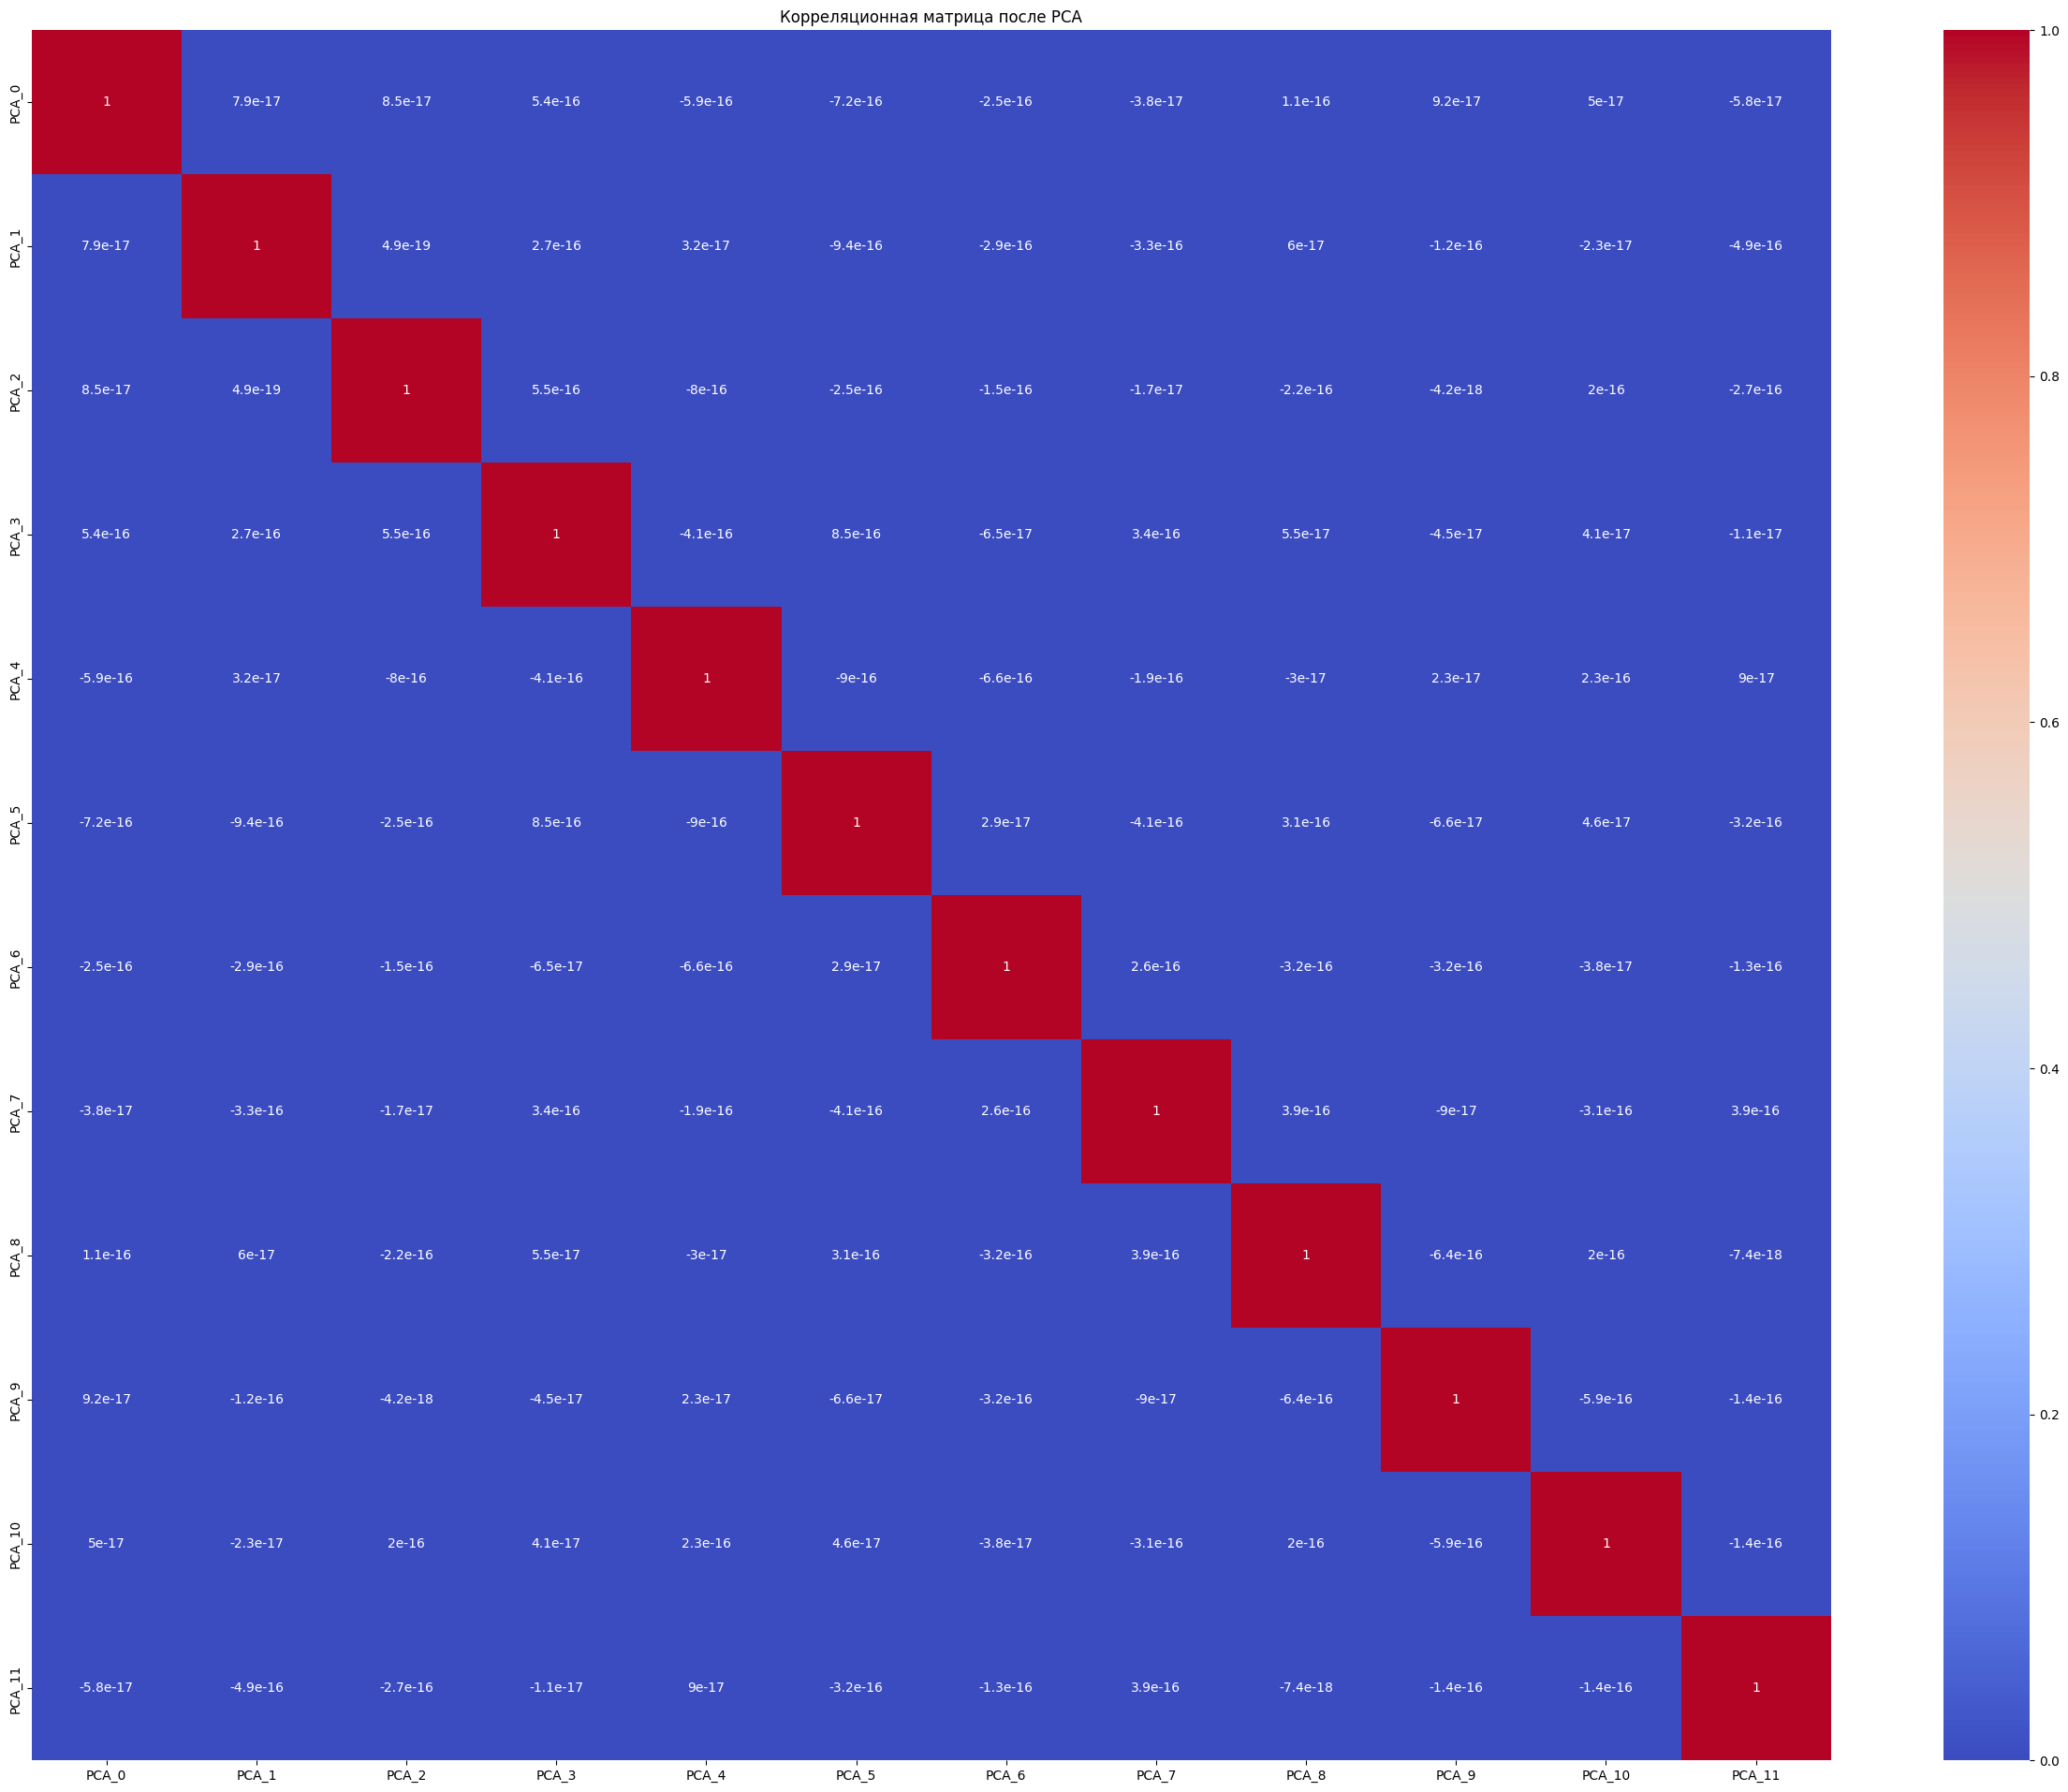

In [421]:
correlation_matrix = X_pca.corr()
plt.figure(figsize=(31,24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица после PCA')
plt.show()

In [422]:
idx_train_val, idx_test = train_test_split(np.arange(len(X)), test_size=0.1, random_state=42, stratify=y)
idx_train, idx_val = train_test_split(idx_train_val, test_size=1/9, random_state=42, stratify=y[idx_train_val])

X_train, X_val, X_test = X.iloc[idx_train], X.iloc[idx_val], X.iloc[idx_test]
y_train, y_val, y_test = y.iloc[idx_train], y.iloc[idx_val], y.iloc[idx_test]

X_train_pca, X_val_pca, X_test_pca = X_pca.iloc[idx_train], X_pca.iloc[idx_val], X_pca.iloc[idx_test]

# Train - 80%
# Validation - 10%
# Train - 10%

In [423]:
scaler = StandardScaler()

X_train_scaled_pca = scaler.fit_transform(X_train_pca)
X_val_scaled_pca = scaler.transform(X_val_pca)
X_test_scaled_pca = scaler.transform(X_test_pca)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 3. Вспомогательный функции

In [424]:
def plot_roc_pr_curves(model, X, y, sample_weight=None):
    y_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, roc_thresholds = roc_curve(y, y_proba, sample_weight = sample_weight)
    precision, recall, _ = precision_recall_curve(y, y_proba, sample_weight = sample_weight)
    
    f1_scores = [f1_score(y, (y_proba >= t).astype(int), sample_weight = sample_weight) for t in roc_thresholds]
    optimal_idX = np.argmax(f1_scores) 
    
    optimal_threshold = roc_thresholds[optimal_idX]
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc_score(y, y_proba):.3f}')
    plt.scatter(fpr[optimal_idX], tpr[optimal_idX], c = 'red', label = f'Threshold = {optimal_threshold:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label = f'PR AUC = {average_precision_score(y, y_proba):.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Оптимальный порог: {optimal_threshold:.4f}")
    return optimal_threshold

In [425]:
def evaluate_classifier(model, X, y, model_name='Model', threshold=0.5, sample_weight=None):    
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    metrics = {
        'Accuracy': accuracy_score(y, y_pred, sample_weight=sample_weight),
        'Balanced Accuracy': balanced_accuracy_score(y, y_pred, sample_weight=sample_weight),
        'Precision': precision_score(y, y_pred, sample_weight=sample_weight),
        'Recall': recall_score(y, y_pred, sample_weight=sample_weight),
        'F1': f1_score(y, y_pred, sample_weight=sample_weight),
        'ROC AUC': roc_auc_score(y, y_proba, sample_weight=sample_weight),  
        'PR AUC': average_precision_score(y, y_proba, sample_weight=sample_weight),
        'Threshold': threshold
    }
    
    plt.figure(figsize=(6, 6))
    cm = confusion_matrix(y, y_pred, sample_weight = sample_weight)
    sns.heatmap(cm, annot=True, fmt='.3g' if sample_weight is not None else 'd',
                cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f'Матрика ошибок (Threshold = {threshold:.4f})')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Действительный класс')
    plt.show()
    
    print(f"\n{'=' * 60}")
    print(f"{' ' * 10}{model_name} - метрики качества")
    print('=' * 60)
    for name, value in metrics.items():
        print(f"{name:<20}: {value:.4f}" if isinstance(value, (int, float)) else f"{name:<20}: {value}")
    
    return metrics

In [426]:
def convert_np(obj):
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()

In [427]:
def save_params(params, filepath):
    with open(filepath, 'w', encoding = 'utf-8') as f:
        json.dump(params, f, indent = 4, ensure_ascii = False, default = convert_np)

In [428]:
def load_params(filepath):
    with open(filepath, 'r', encoding = 'utf-8') as f:
        params = json.load(f)

    return params

In [429]:
def find_best_params(model, X, y, parameters_grid, filepath, iters = 15, cv = 5, n_jobs = -1):   
    try: 
        params = load_params(filepath)
        return params
    
    except:
        clf = RandomizedSearchCV(model, parameters_grid, scoring = 'f1_micro', verbose = 2, n_iter = iters, cv = cv, n_jobs = n_jobs, random_state = 42)
        clf.fit(X, y)

        params = clf.best_params_
        save_params(params, filepath)

        return params

In [430]:
def add_metrics_to_df(name, metrics_dict, df = None):
    if df is None:
        df = pd.DataFrame(columns=['Model'] + list(metrics_dict.keys()))
    
    new_row = {'Model': name}
    new_row.update(metrics_dict)

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    
    return df

In [431]:
def find_best_models(results_df):
    metrics = [col for col in results_df.columns if col not in ['Model', 'Threshold']]
    
    best_models = {
        metric: (
            results_df.loc[results_df[metric].idxmax(), 'Model'],  
            results_df[metric].max()                            
        ) for metric in metrics
    }
    
    return pd.DataFrame.from_dict(best_models, orient='index', columns=['Best Model', 'Value'])

In [432]:
def feature_importances_plot(model, names):
    model_feature_importances = model.feature_importances_

    model_features = dict()
    norm = sum(model_feature_importances)
    for i in range(len(names)):
        model_features[names[i]] = model_feature_importances[i] / norm

    model_features = sorted(model_features.items(), key=lambda item: item[1])

    df_importance = pd.DataFrame(model_features, columns = ['Feature', 'Importance'])

    plt.figure(figsize = (17, 10))
    sns.barplot(data = df_importance, x = 'Feature', y = 'Importance')

    plt.xticks(rotation = 90, ha ='right')

    plt.title(r'Важность признаков')
    plt.xlabel('Название')
    plt.ylabel('Важность')
    plt.grid(True)
    plt.show()

# 4. Базовые модели - рассмотрим для начала Наивный Байесовский Классификатор и KNN

## Начнем с Наивного Байесовского Классификатора

In [433]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

nb_pca = GaussianNB()
nb_pca.fit(X_train_scaled_pca, y_train)

GaussianNB()

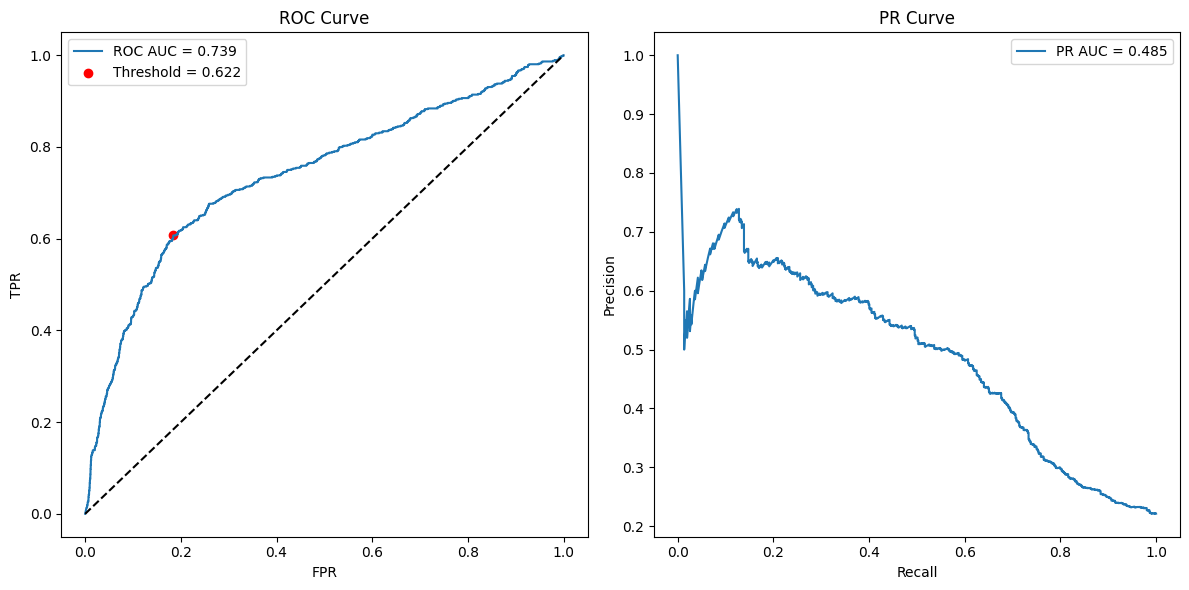

Оптимальный порог: 0.6223


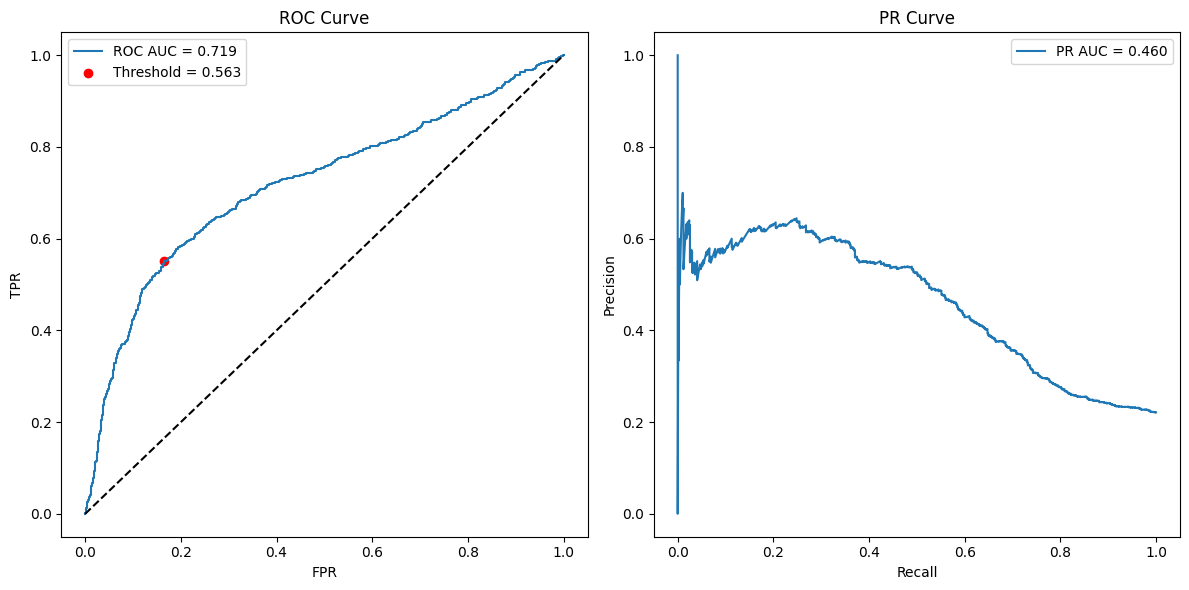

Оптимальный порог: 0.5629


In [434]:
optimal_nb = plot_roc_pr_curves(nb, X_val_scaled, y_val)
optimal_nb_pca = plot_roc_pr_curves(nb_pca, X_val_scaled_pca, y_val)

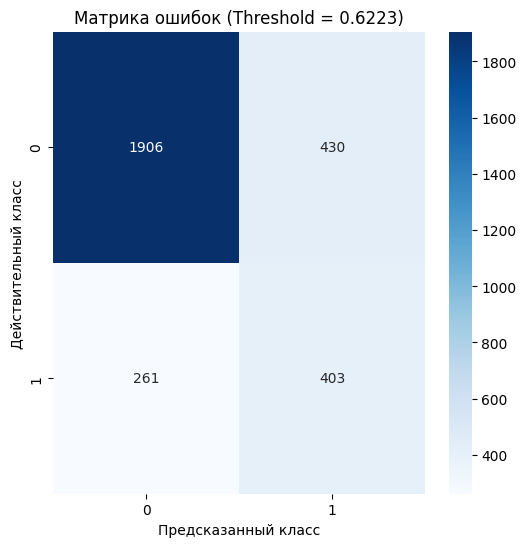


          NB Классификатор - метрики качества
Accuracy            : 0.7697
Balanced Accuracy   : 0.7114
Precision           : 0.4838
Recall              : 0.6069
F1                  : 0.5384
ROC AUC             : 0.7386
PR AUC              : 0.4851
Threshold           : 0.6223


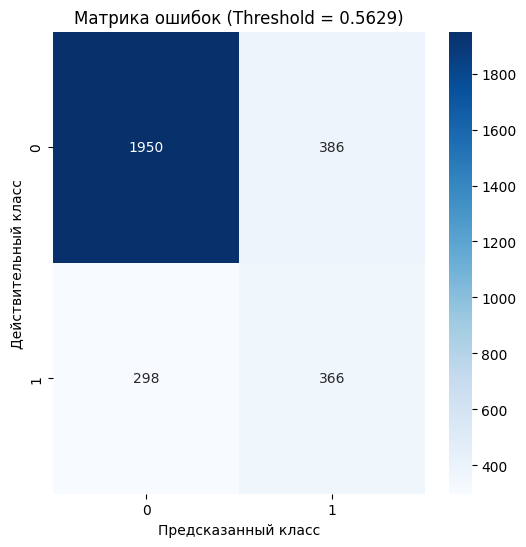


          NB_pca Классификатор - метрики качества
Accuracy            : 0.7720
Balanced Accuracy   : 0.6930
Precision           : 0.4867
Recall              : 0.5512
F1                  : 0.5169
ROC AUC             : 0.7193
PR AUC              : 0.4604
Threshold           : 0.5629


In [435]:
metrics_nb = evaluate_classifier(nb, X_val_scaled, y_val, model_name = 'NB Классификатор', threshold = optimal_nb)
metrics_nb_pca = evaluate_classifier(nb_pca, X_val_scaled_pca, y_val, model_name = 'NB_pca Классификатор', threshold = optimal_nb_pca)

Неплохо, особенно без PCA.

In [436]:
СompareDF = add_metrics_to_df('NB', metrics_nb)
СompareDF = add_metrics_to_df('NB_pca', metrics_nb_pca, СompareDF)
СompareDF

C:\Users\Terol19\AppData\Local\Temp\ipykernel_31552\688105740.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


Model  Accuracy  Balanced Accuracy  Precision    Recall        F1  \
0      NB  0.769667           0.711426   0.483794  0.606928  0.538410   
1  NB_pca  0.772000           0.692983   0.486702  0.551205  0.516949   

    ROC AUC    PR AUC  Threshold  
0  0.738629  0.485081   0.622346  
1  0.719346  0.460381   0.562912

## Теперь KNN

In [437]:
KNN_0 = KNeighborsClassifier()
KNN_0.fit(X_train_scaled, y_train)

KNN_pca_0 = KNeighborsClassifier()
KNN_pca_0.fit(X_train_scaled_pca, y_train)

KNeighborsClassifier()

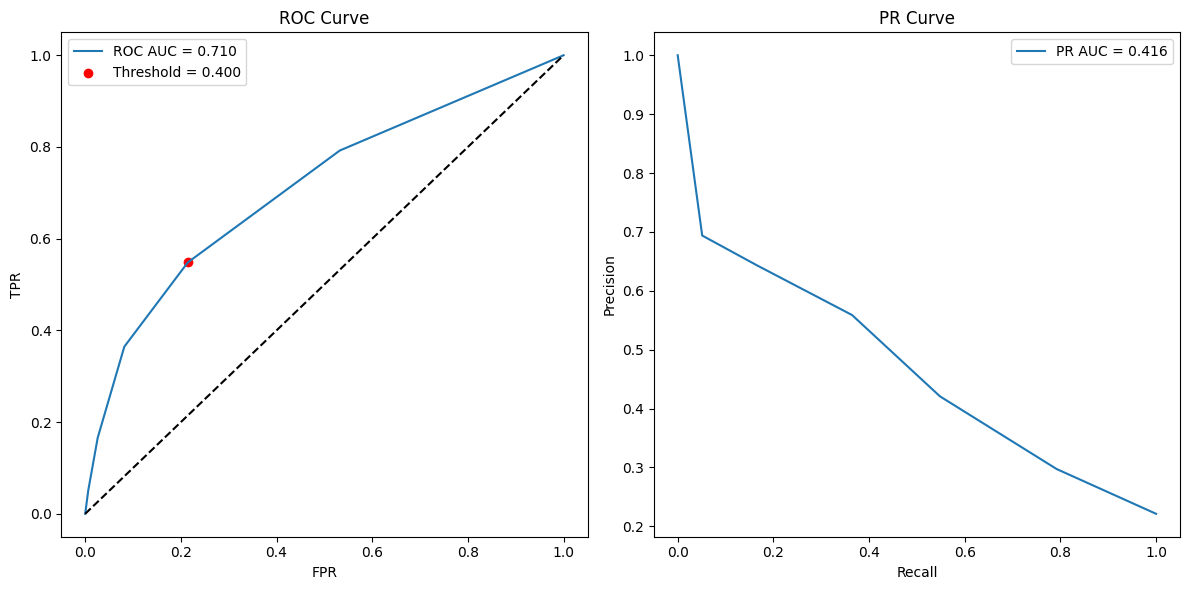

Оптимальный порог: 0.4000


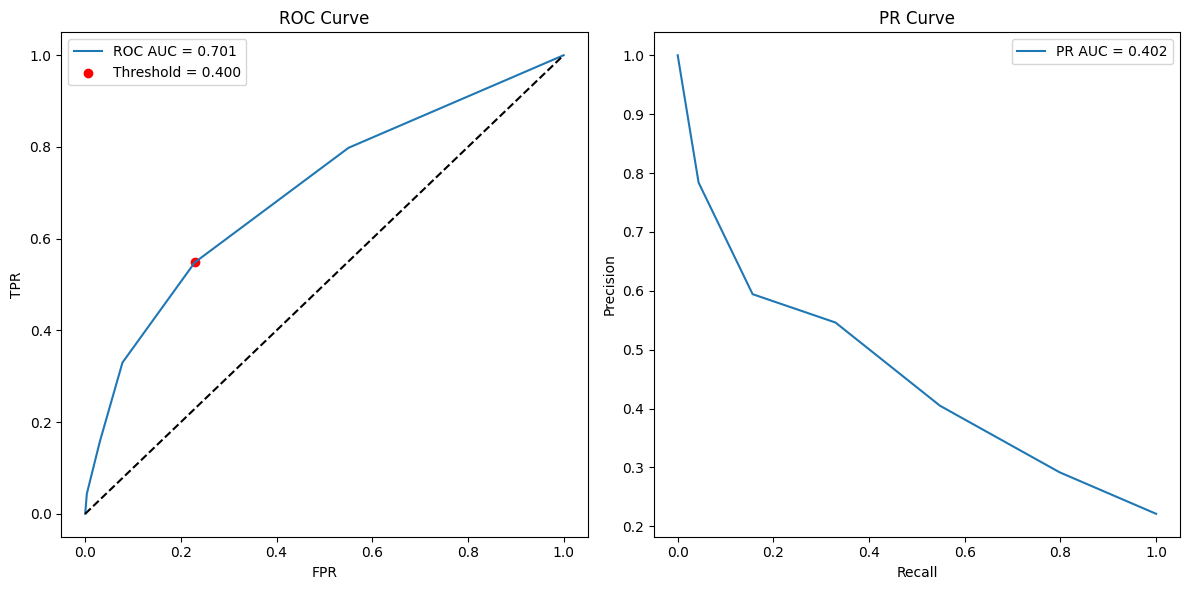

Оптимальный порог: 0.4000


In [438]:
optimal_KNN_0 = plot_roc_pr_curves(KNN_0, X_val_scaled, y_val)
optimal_KNN_pca_0 = plot_roc_pr_curves(KNN_pca_0, X_val_scaled_pca, y_val)

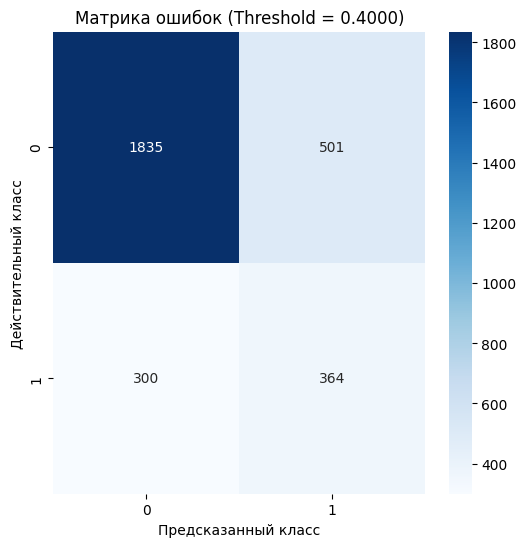


          KNN_0 Классификатор - метрики качества
Accuracy            : 0.7330
Balanced Accuracy   : 0.6669
Precision           : 0.4208
Recall              : 0.5482
F1                  : 0.4761
ROC AUC             : 0.7098
PR AUC              : 0.4161
Threshold           : 0.4000


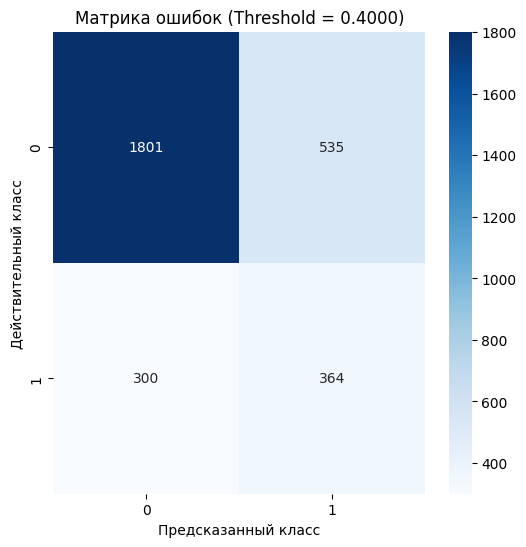


          KNN_pca_0 Классификатор - метрики качества
Accuracy            : 0.7217
Balanced Accuracy   : 0.6596
Precision           : 0.4049
Recall              : 0.5482
F1                  : 0.4658
ROC AUC             : 0.7012
PR AUC              : 0.4020
Threshold           : 0.4000


In [439]:
metrics_KNN_0 = evaluate_classifier(KNN_0, X_val_scaled, y_val, model_name = 'KNN_0 Классификатор', threshold = optimal_KNN_0)
metrics_KNN_pca_0 = evaluate_classifier(KNN_pca_0, X_val_scaled_pca, y_val, model_name = 'KNN_pca_0 Классификатор', threshold = optimal_KNN_pca_0)

In [440]:
СompareDF = add_metrics_to_df('KNN_0', metrics_KNN_0, СompareDF)
СompareDF = add_metrics_to_df('KNN_pca_0', metrics_KNN_pca_0, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall        F1  \
0         NB  0.769667           0.711426   0.483794  0.606928  0.538410   
1     NB_pca  0.772000           0.692983   0.486702  0.551205  0.516949   
2      KNN_0  0.733000           0.666862   0.420809  0.548193  0.476128   
3  KNN_pca_0  0.721667           0.659584   0.404894  0.548193  0.465771   

    ROC AUC    PR AUC  Threshold  
0  0.738629  0.485081   0.622346  
1  0.719346  0.460381   0.562912  
2  0.709754  0.416125   0.400000  
3  0.701229  0.401991   0.400000

### Слабее чем Gaussian Naive Bayes. Подберем параметры.

In [441]:
parameters = {'n_neighbors': np.arange(1, 100),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1, 2, np.inf]}

KNN_1_params = find_best_params(KNeighborsClassifier(), X_train_scaled, y_train, parameters, 'Params/KNN_1_params.json', iters = 50)
KNN_pca_1_params = find_best_params(KNeighborsClassifier(), X_train_scaled_pca, y_train, parameters, 'Params/KNN_pca_1_params.json', iters = 50)

print(KNN_1_params)
print(KNN_pca_1_params)

{'weights': 'uniform', 'p': inf, 'n_neighbors': 75, 'algorithm': 'brute'}
{'weights': 'distance', 'p': 2, 'n_neighbors': 36, 'algorithm': 'brute'}


In [442]:
KNN_1 = KNeighborsClassifier(**KNN_1_params)
KNN_1.fit(X_train_scaled, y_train)

KNN_pca_1 = KNeighborsClassifier(**KNN_pca_1_params)
KNN_pca_1.fit(X_train_scaled_pca, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=36, weights='distance')

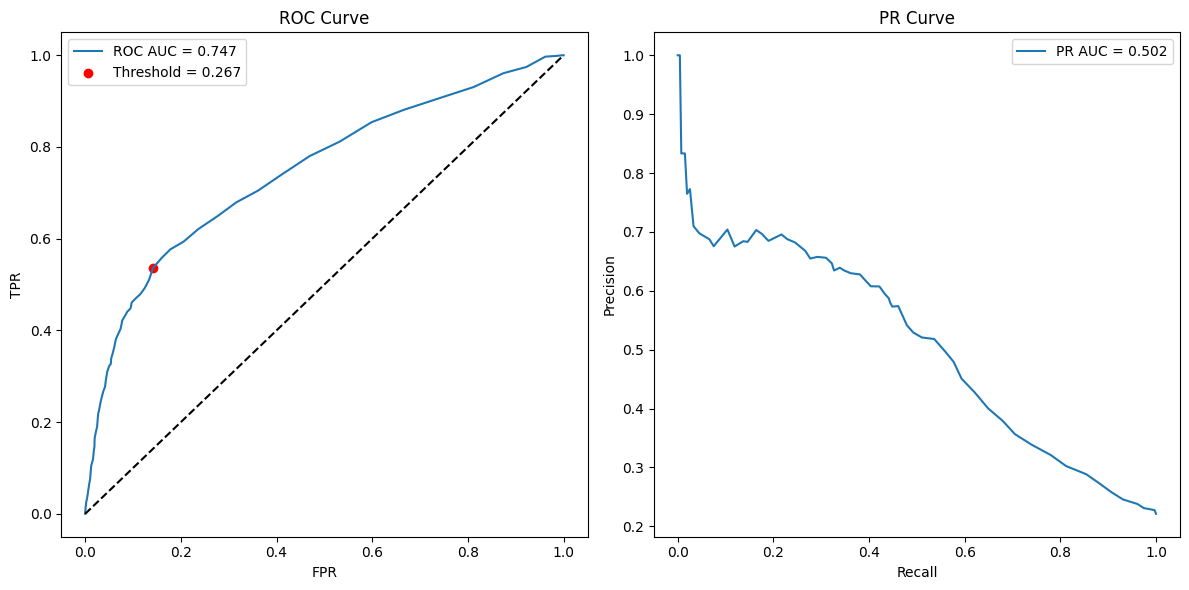

Оптимальный порог: 0.2667


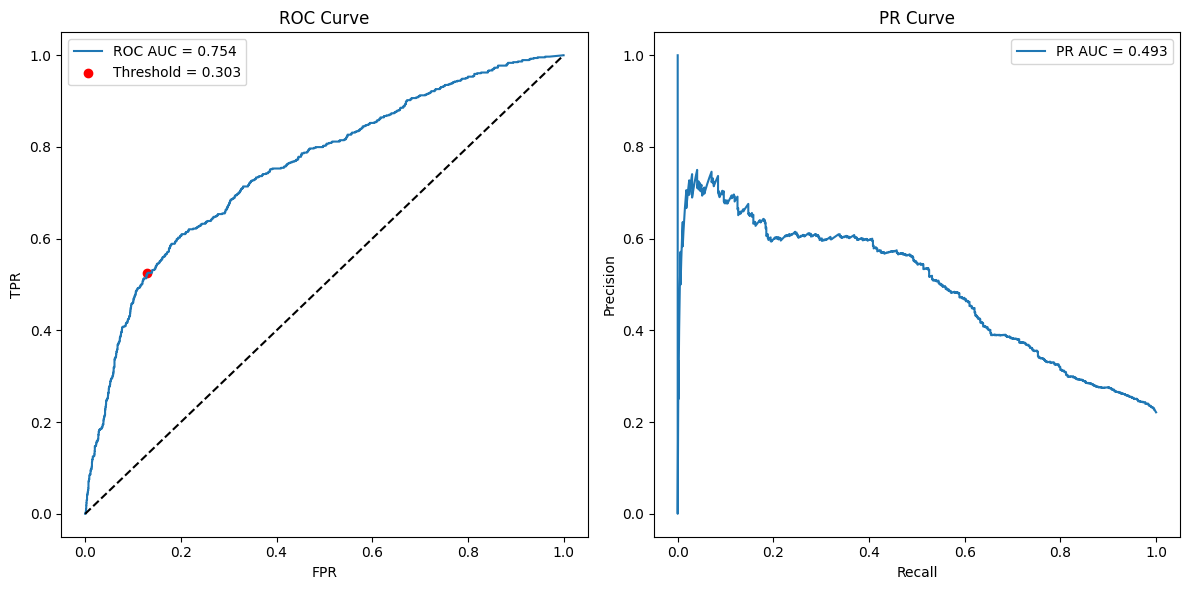

Оптимальный порог: 0.3030


In [443]:
optimal_KNN_1 = plot_roc_pr_curves(KNN_1, X_val_scaled, y_val)
optimal_KNN_pca_1 = plot_roc_pr_curves(KNN_pca_1, X_val_scaled_pca, y_val)

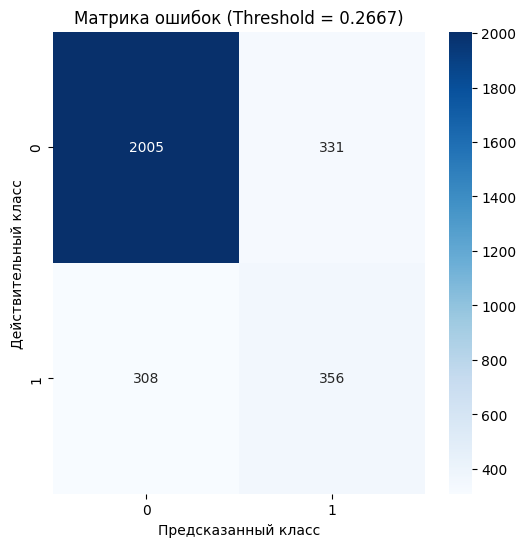


          KNN_1 Классификатор - метрики качества
Accuracy            : 0.7870
Balanced Accuracy   : 0.6972
Precision           : 0.5182
Recall              : 0.5361
F1                  : 0.5270
ROC AUC             : 0.7467
PR AUC              : 0.5021
Threshold           : 0.2667


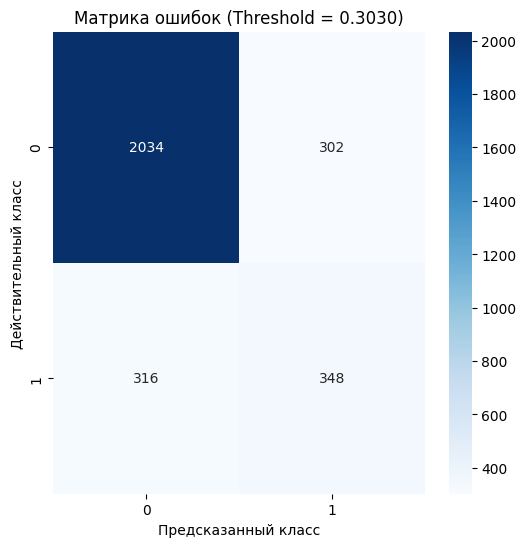


          KNN_pca_1 Классификатор - метрики качества
Accuracy            : 0.7940
Balanced Accuracy   : 0.6974
Precision           : 0.5354
Recall              : 0.5241
F1                  : 0.5297
ROC AUC             : 0.7545
PR AUC              : 0.4935
Threshold           : 0.3030


In [444]:
metrics_KNN_1 = evaluate_classifier(KNN_1, X_val_scaled, y_val, model_name = 'KNN_1 Классификатор', threshold = optimal_KNN_1)
metrics_KNN_pca_1 = evaluate_classifier(KNN_pca_1, X_val_scaled_pca, y_val, model_name = 'KNN_pca_1 Классификатор', threshold = optimal_KNN_pca_1)

In [445]:
СompareDF = add_metrics_to_df('KNN_1', metrics_KNN_1, СompareDF)
СompareDF = add_metrics_to_df('KNN_pca_1', metrics_KNN_pca_1, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall        F1  \
0         NB  0.769667           0.711426   0.483794  0.606928  0.538410   
1     NB_pca  0.772000           0.692983   0.486702  0.551205  0.516949   
2      KNN_0  0.733000           0.666862   0.420809  0.548193  0.476128   
3  KNN_pca_0  0.721667           0.659584   0.404894  0.548193  0.465771   
4      KNN_1  0.787000           0.697225   0.518195  0.536145  0.527017   
5  KNN_pca_1  0.794000           0.697408   0.535385  0.524096  0.529680   

    ROC AUC    PR AUC  Threshold  
0  0.738629  0.485081   0.622346  
1  0.719346  0.460381   0.562912  
2  0.709754  0.416125   0.400000  
3  0.701229  0.401991   0.400000  
4  0.746651  0.502086   0.266667  
5  0.754495  0.493477   0.303050

## Видим, что KNN даже после подбора гиперпараметров хуже Наивного Байесовского Классификатора по F1 (однако, ROC AUC лучше).

# 5. Рассмотрим SVM

In [446]:
SVM_0 = SVC(probability = True, verbose = True)
SVM_0.fit(X_train_scaled, y_train)

SVM_pca_0 = SVC(probability = True, verbose = True)
SVM_pca_0.fit(X_train_scaled_pca, y_train)

[LibSVM][LibSVM]

SVC(probability=True, verbose=True)

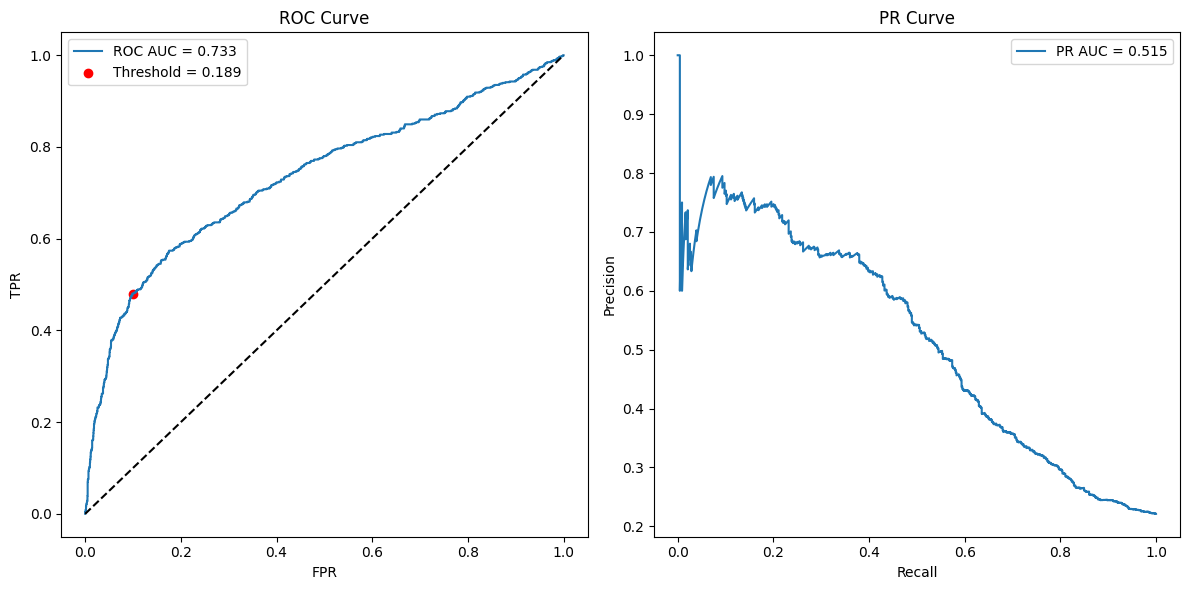

Оптимальный порог: 0.1891


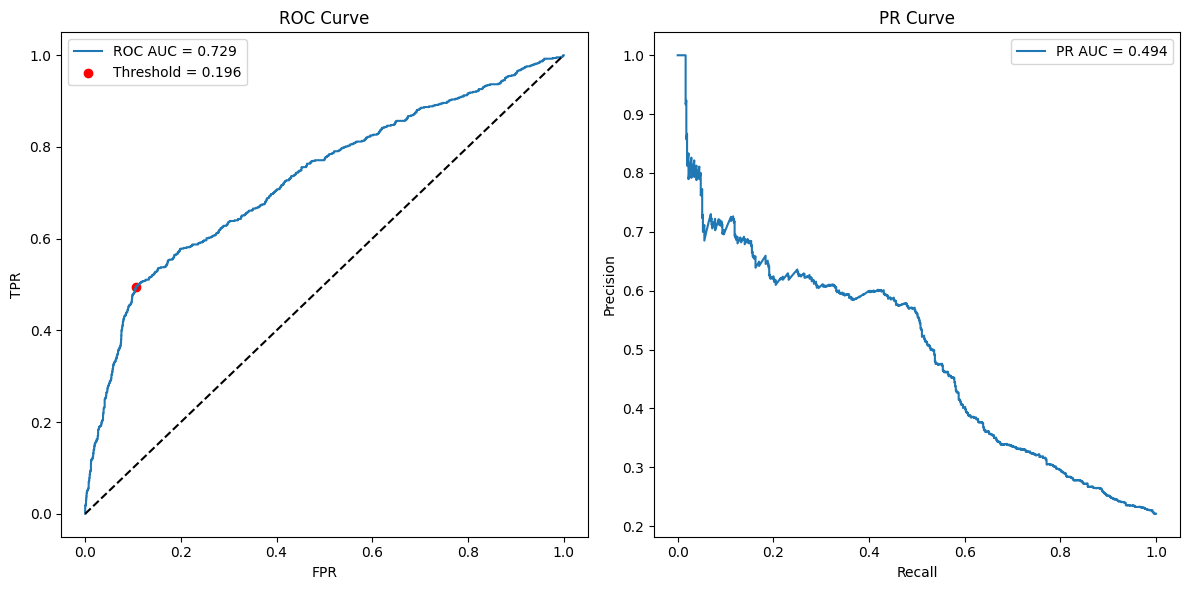

Оптимальный порог: 0.1963


In [447]:
optimal_SVM_0 = plot_roc_pr_curves(SVM_0, X_val_scaled, y_val)
optimal_SVM_pca_0 = plot_roc_pr_curves(SVM_pca_0, X_val_scaled_pca, y_val)

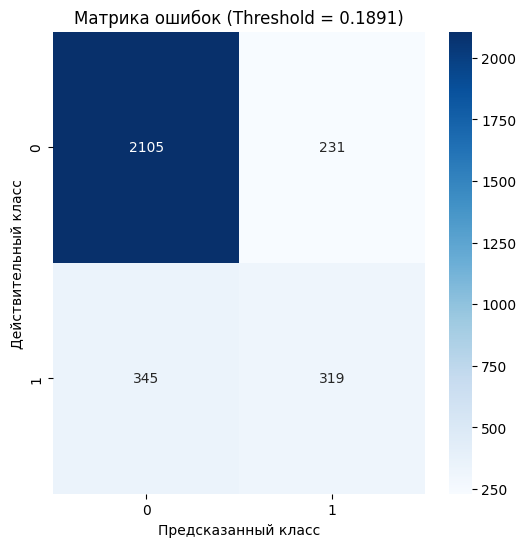


          SVM_0 Классификатор - метрики качества
Accuracy            : 0.8080
Balanced Accuracy   : 0.6908
Precision           : 0.5800
Recall              : 0.4804
F1                  : 0.5255
ROC AUC             : 0.7330
PR AUC              : 0.5149
Threshold           : 0.1891


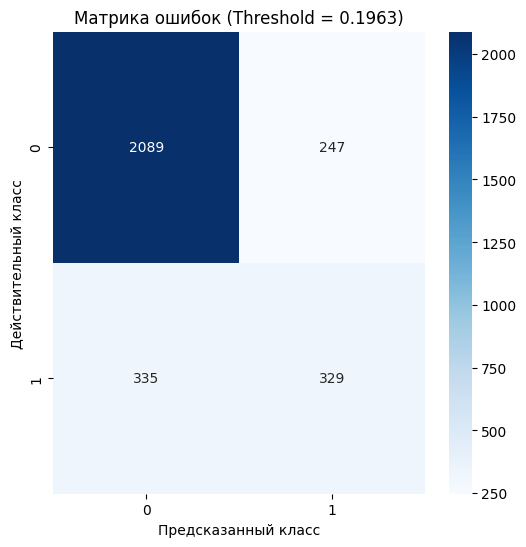


          SVM_pca_0 Классификатор - метрики качества
Accuracy            : 0.8060
Balanced Accuracy   : 0.6949
Precision           : 0.5712
Recall              : 0.4955
F1                  : 0.5306
ROC AUC             : 0.7285
PR AUC              : 0.4941
Threshold           : 0.1963


In [448]:
metrics_SVM_0 = evaluate_classifier(SVM_0, X_val_scaled, y_val, model_name = 'SVM_0 Классификатор', threshold = optimal_SVM_0)
metrics_SVM_pca_0 = evaluate_classifier(SVM_pca_0, X_val_scaled_pca, y_val, model_name = 'SVM_pca_0 Классификатор', threshold = optimal_SVM_pca_0)

In [449]:
СompareDF = add_metrics_to_df('SVM_0', metrics_SVM_0, СompareDF)
СompareDF = add_metrics_to_df('SVM_pca_0', metrics_SVM_pca_0, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall        F1  \
0         NB  0.769667           0.711426   0.483794  0.606928  0.538410   
1     NB_pca  0.772000           0.692983   0.486702  0.551205  0.516949   
2      KNN_0  0.733000           0.666862   0.420809  0.548193  0.476128   
3  KNN_pca_0  0.721667           0.659584   0.404894  0.548193  0.465771   
4      KNN_1  0.787000           0.697225   0.518195  0.536145  0.527017   
5  KNN_pca_1  0.794000           0.697408   0.535385  0.524096  0.529680   
6      SVM_0  0.808000           0.690767   0.580000  0.480422  0.525535   
7  SVM_pca_0  0.806000           0.694873   0.571181  0.495482  0.530645   

    ROC AUC    PR AUC  Threshold  
0  0.738629  0.485081   0.622346  
1  0.719346  0.460381   0.562912  
2  0.709754  0.416125   0.400000  
3  0.701229  0.401991   0.400000  
4  0.746651  0.502086   0.266667  
5  0.754495  0.493477   0.303050  
6  0.732955  0.514870   0.189060  
7  0.728542  0.494067   0.196265

### Сравнимо с NB. Подберем параметры.

In [450]:
parameters = {'C': np.logspace(-2, 2, 5),
              'kernel': ['poly', 'rbf',],
              'degree': np.arange(2, 7)}

SVM_1_params = find_best_params(SVC(probability = False), X_train_scaled, y_train, parameters, 'Params/SVM_1_params.json', iters = 10, cv = 3, n_jobs = 1)
SVM_pca_1_params = find_best_params(SVC(probability = False), X_train_scaled_pca, y_train, parameters, 'Params/SVM_pca_1_params.json', iters = 10, cv = 3, n_jobs = 1)
print(SVM_1_params)
print(SVM_pca_1_params)

{'C': 0.01, 'kernel': 'rbf', 'gamma': 'scale'}
{'C': 0.01, 'kernel': 'rbf', 'gamma': 'scale'}


In [451]:
SVM_1 = SVC(probability = True, **SVM_1_params)
SVM_1.fit(X_train_scaled, y_train)

SVM_pca_1 = SVC(probability = True, **SVM_pca_1_params)
SVM_pca_1.fit(X_train_scaled_pca, y_train)

SVC(C=0.01, probability=True)

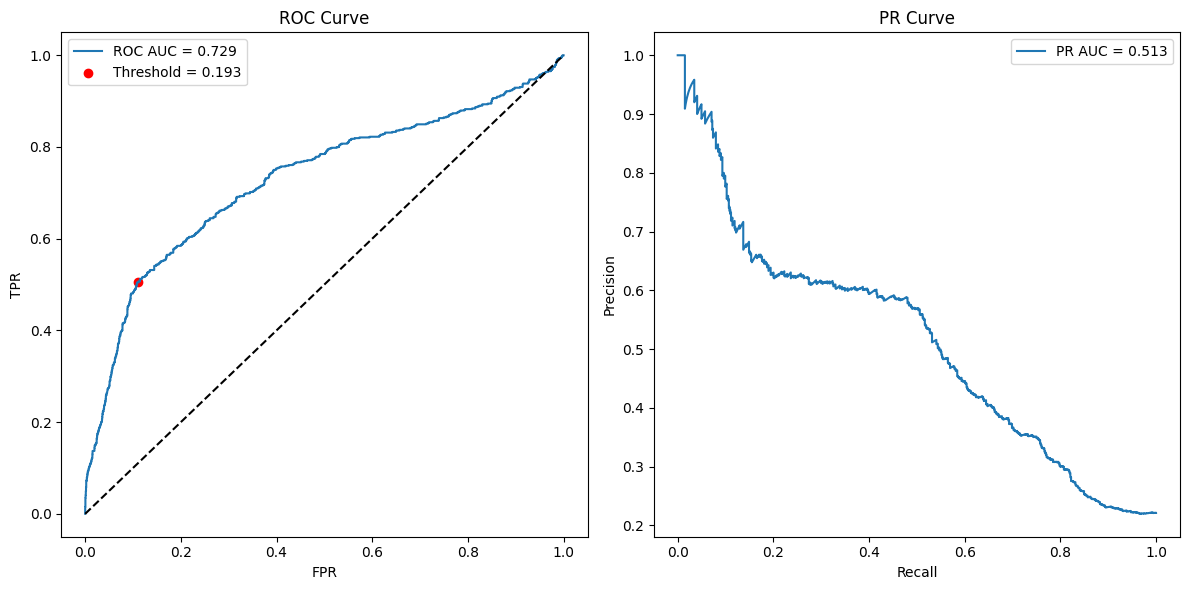

Оптимальный порог: 0.1926


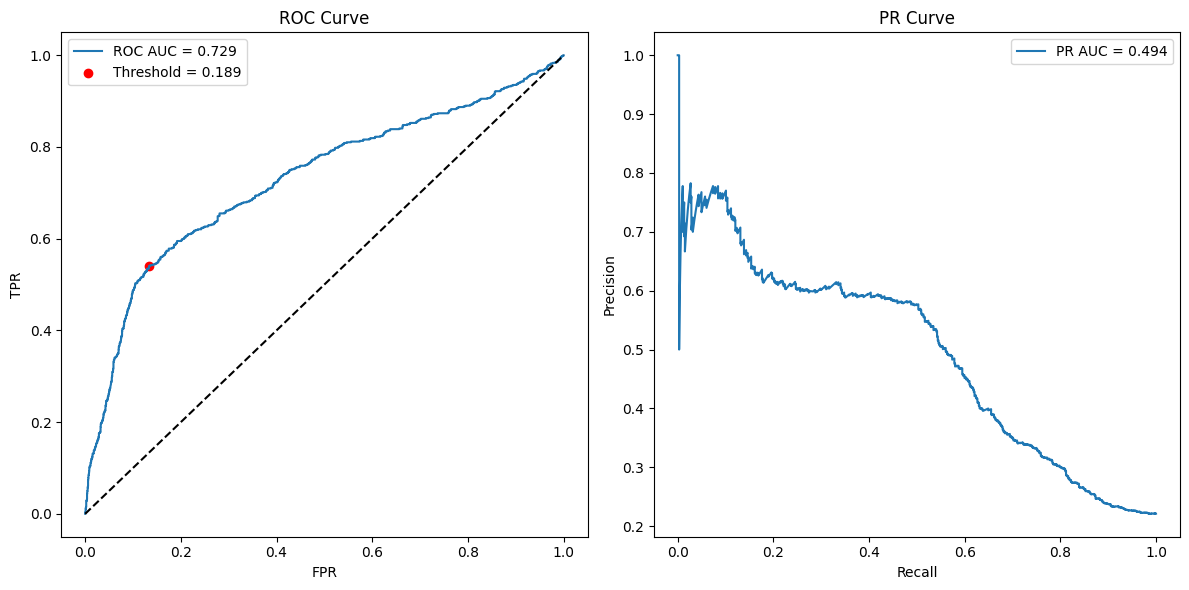

Оптимальный порог: 0.1886


In [452]:
optimal_SVM_1 = plot_roc_pr_curves(SVM_1, X_val_scaled, y_val)
optimal_SVM_pca_1 = plot_roc_pr_curves(SVM_pca_1, X_val_scaled_pca, y_val)

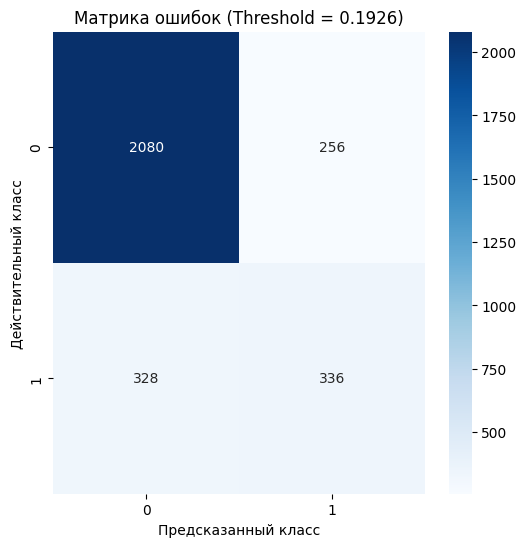


          SVM_1 Классификатор - метрики качества
Accuracy            : 0.8053
Balanced Accuracy   : 0.6982
Precision           : 0.5676
Recall              : 0.5060
F1                  : 0.5350
ROC AUC             : 0.7295
PR AUC              : 0.5132
Threshold           : 0.1926


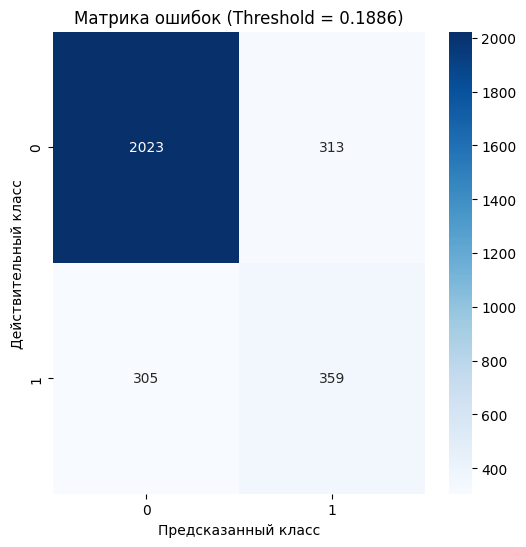


          SVM_pca_1 Классификатор - метрики качества
Accuracy            : 0.7940
Balanced Accuracy   : 0.7033
Precision           : 0.5342
Recall              : 0.5407
F1                  : 0.5374
ROC AUC             : 0.7292
PR AUC              : 0.4943
Threshold           : 0.1886


In [453]:
metrics_SVM_1 = evaluate_classifier(SVM_1, X_val_scaled, y_val, model_name = 'SVM_1 Классификатор', threshold = optimal_SVM_1)
metrics_SVM_pca_1 = evaluate_classifier(SVM_pca_1, X_val_scaled_pca, y_val, model_name = 'SVM_pca_1 Классификатор', threshold = optimal_SVM_pca_1)

In [454]:
СompareDF = add_metrics_to_df('SVM_1', metrics_SVM_1, СompareDF)
СompareDF = add_metrics_to_df('SVM_pca_1', metrics_SVM_pca_1, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall        F1  \
0         NB  0.769667           0.711426   0.483794  0.606928  0.538410   
1     NB_pca  0.772000           0.692983   0.486702  0.551205  0.516949   
2      KNN_0  0.733000           0.666862   0.420809  0.548193  0.476128   
3  KNN_pca_0  0.721667           0.659584   0.404894  0.548193  0.465771   
4      KNN_1  0.787000           0.697225   0.518195  0.536145  0.527017   
5  KNN_pca_1  0.794000           0.697408   0.535385  0.524096  0.529680   
6      SVM_0  0.808000           0.690767   0.580000  0.480422  0.525535   
7  SVM_pca_0  0.806000           0.694873   0.571181  0.495482  0.530645   
8      SVM_1  0.805333           0.698218   0.567568  0.506024  0.535032   
9  SVM_pca_1  0.794000           0.703336   0.534226  0.540663  0.537425   

    ROC AUC    PR AUC  Threshold  
0  0.738629  0.485081   0.622346  
1  0.719346  0.460381   0.562912  
2  0.709754  0.416125   0.400000  
3  0.701229  0.401991   0.400000  
4  0.746651  0.502086   0.266667  
5  0.754495  0.493477   0.303050  
6  0.732955  0.514870   0.189060  
7  0.728542  0.494067   0.196265  
8  0.729463  0.513233   0.192587  
9  0.729168  0.494315   0.188591

# 6. Рассмотрим логистическую регрессию

In [455]:
LogReg_0 = LogisticRegression()
LogReg_0.fit(X_train_scaled, y_train)

LogReg_pca_0 = LogisticRegression()
LogReg_pca_0.fit(X_train_scaled_pca, y_train)

LogisticRegression()

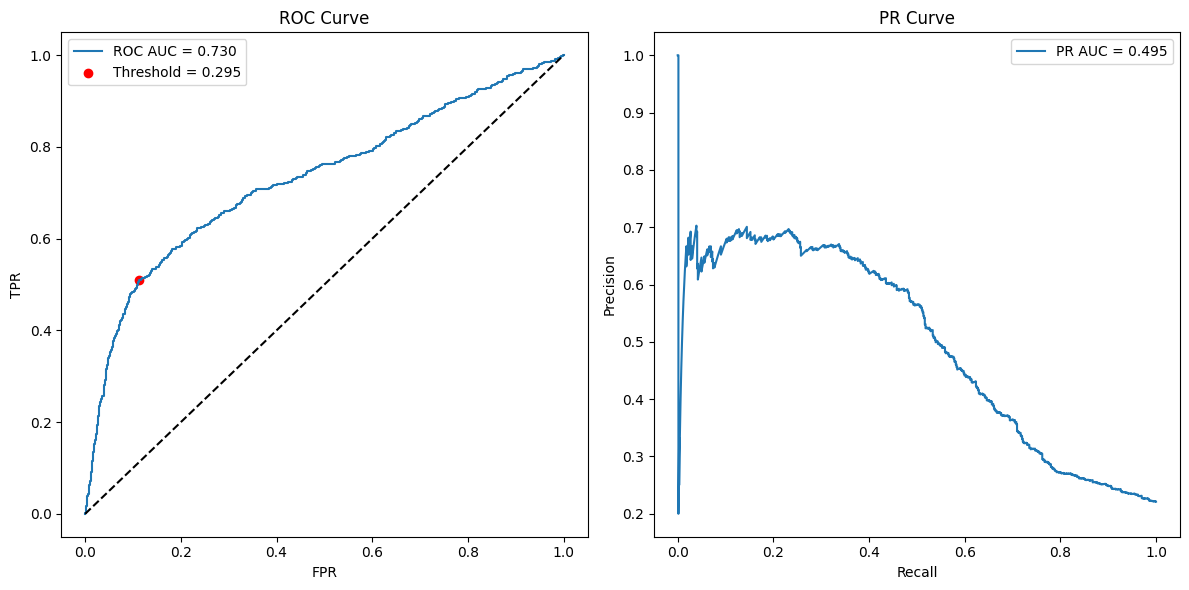

Оптимальный порог: 0.2951


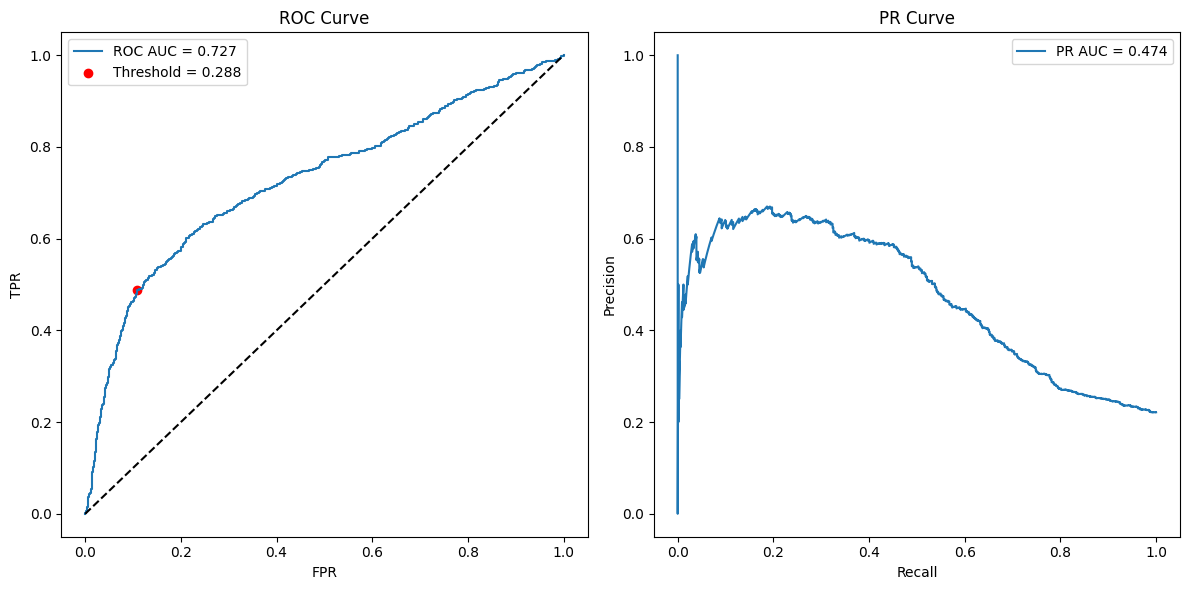

Оптимальный порог: 0.2876


In [456]:
optimal_LogReg_0 = plot_roc_pr_curves(LogReg_0, X_val_scaled, y_val)
optimal_LogReg_pca_0 = plot_roc_pr_curves(LogReg_pca_0, X_val_scaled_pca, y_val)

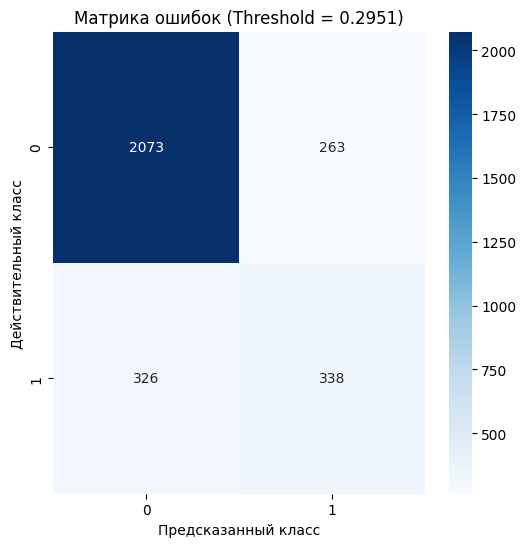


          LogReg_0 Классификатор - метрики качества
Accuracy            : 0.8037
Balanced Accuracy   : 0.6982
Precision           : 0.5624
Recall              : 0.5090
F1                  : 0.5344
ROC AUC             : 0.7305
PR AUC              : 0.4955
Threshold           : 0.2951


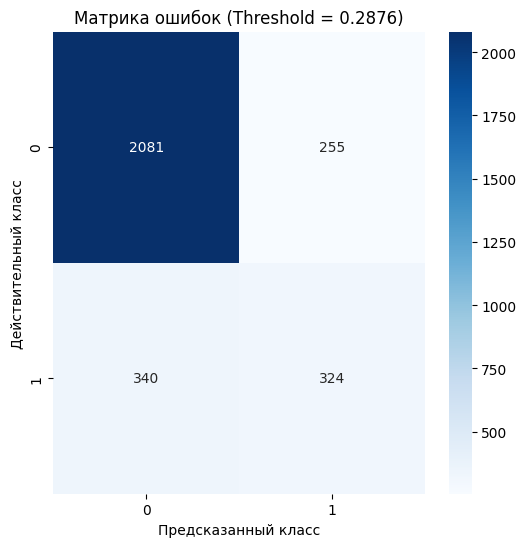


          LogReg_pca_0 Классификатор - метрики качества
Accuracy            : 0.8017
Balanced Accuracy   : 0.6894
Precision           : 0.5596
Recall              : 0.4880
F1                  : 0.5213
ROC AUC             : 0.7271
PR AUC              : 0.4737
Threshold           : 0.2876


In [457]:
metrics_LogReg_0 = evaluate_classifier(LogReg_0, X_val_scaled, y_val, model_name = 'LogReg_0 Классификатор', threshold = optimal_LogReg_0)
metrics_LogReg_pca_0 = evaluate_classifier(LogReg_pca_0, X_val_scaled_pca, y_val, model_name = 'LogReg_pca_0 Классификатор', threshold = optimal_LogReg_pca_0)

In [458]:
СompareDF = add_metrics_to_df('LogReg_0', metrics_LogReg_0, СompareDF)
СompareDF = add_metrics_to_df('LogReg_pca_0', metrics_LogReg_pca_0, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall        F1  \
0             NB  0.769667           0.711426   0.483794  0.606928  0.538410   
1         NB_pca  0.772000           0.692983   0.486702  0.551205  0.516949   
2          KNN_0  0.733000           0.666862   0.420809  0.548193  0.476128   
3      KNN_pca_0  0.721667           0.659584   0.404894  0.548193  0.465771   
4          KNN_1  0.787000           0.697225   0.518195  0.536145  0.527017   
5      KNN_pca_1  0.794000           0.697408   0.535385  0.524096  0.529680   
6          SVM_0  0.808000           0.690767   0.580000  0.480422  0.525535   
7      SVM_pca_0  0.806000           0.694873   0.571181  0.495482  0.530645   
8          SVM_1  0.805333           0.698218   0.567568  0.506024  0.535032   
9      SVM_pca_1  0.794000           0.703336   0.534226  0.540663  0.537425   
10      LogReg_0  0.803667           0.698225   0.562396  0.509036  0.534387   
11  LogReg_pca_0  0.801667           0.689395   0.559585  0.487952  0.521319   

     ROC AUC    PR AUC  Threshold  
0   0.738629  0.485081   0.622346  
1   0.719346  0.460381   0.562912  
2   0.709754  0.416125   0.400000  
3   0.701229  0.401991   0.400000  
4   0.746651  0.502086   0.266667  
5   0.754495  0.493477   0.303050  
6   0.732955  0.514870   0.189060  
7   0.728542  0.494067   0.196265  
8   0.729463  0.513233   0.192587  
9   0.729168  0.494315   0.188591  
10  0.730489  0.495473   0.295051  
11  0.727109  0.473708   0.287607

### Подберем гиперпараметры

In [459]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.logspace(-3, 3, 7),
              'max_iter': np.arange(50, 250, 50),
              'tol': np.logspace(-6, -4, 3),
              'l1_ratio': [0.1, 0.5, 0.9]}

LogReg_1_params = find_best_params(LogisticRegression(solver = 'saga'), X_train_scaled, y_train, parameters, 'Params/LogReg_1_params.json', iters = 100)
LogReg_1_pca_params = find_best_params(LogisticRegression(solver = 'saga'), X_train_scaled_pca, y_train, parameters, 'Params/LogReg_pca_1_params.json', iters = 100)
print(LogReg_1_params)
print(LogReg_1_pca_params)

{'tol': 1e-05, 'penalty': 'l2', 'max_iter': 150, 'l1_ratio': 0.1, 'C': 1.0}
{'tol': 1e-06, 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.9, 'C': 1.0}


In [460]:
LogReg_1 = LogisticRegression(solver = 'saga', **LogReg_1_params)
LogReg_1.fit(X_train_scaled, y_train)

LogReg_pca_1 = LogisticRegression(solver = 'saga', **LogReg_1_pca_params)
LogReg_pca_1.fit(X_train_scaled_pca, y_train)

c:\Users\Terol19\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\Terol19\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Terol19\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


LogisticRegression(l1_ratio=0.9, solver='saga', tol=1e-06)

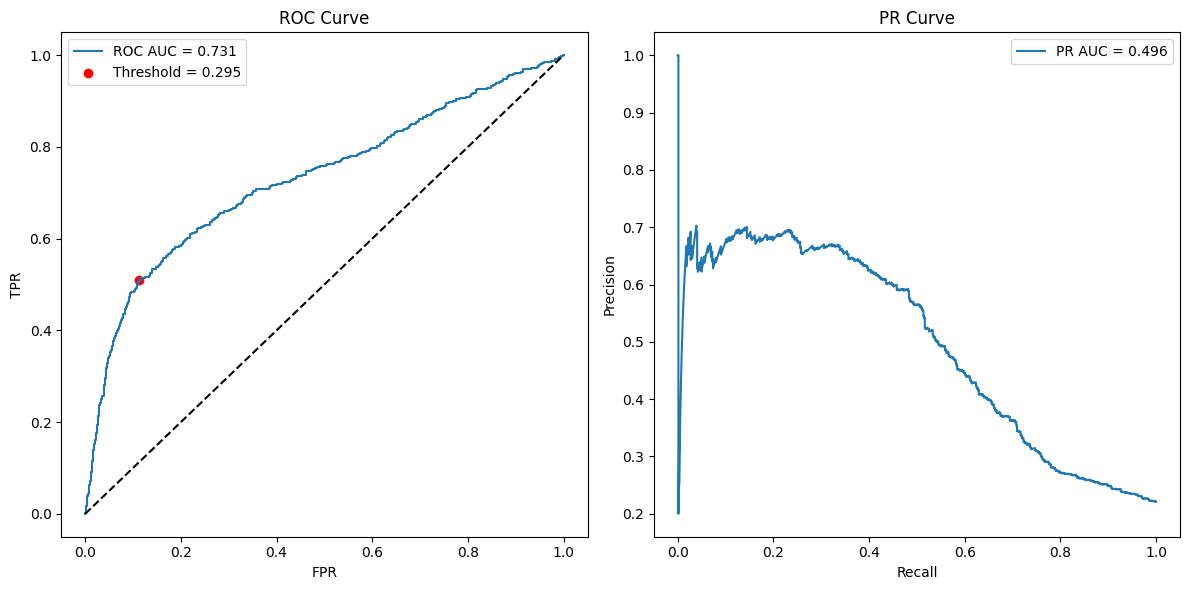

Оптимальный порог: 0.2949


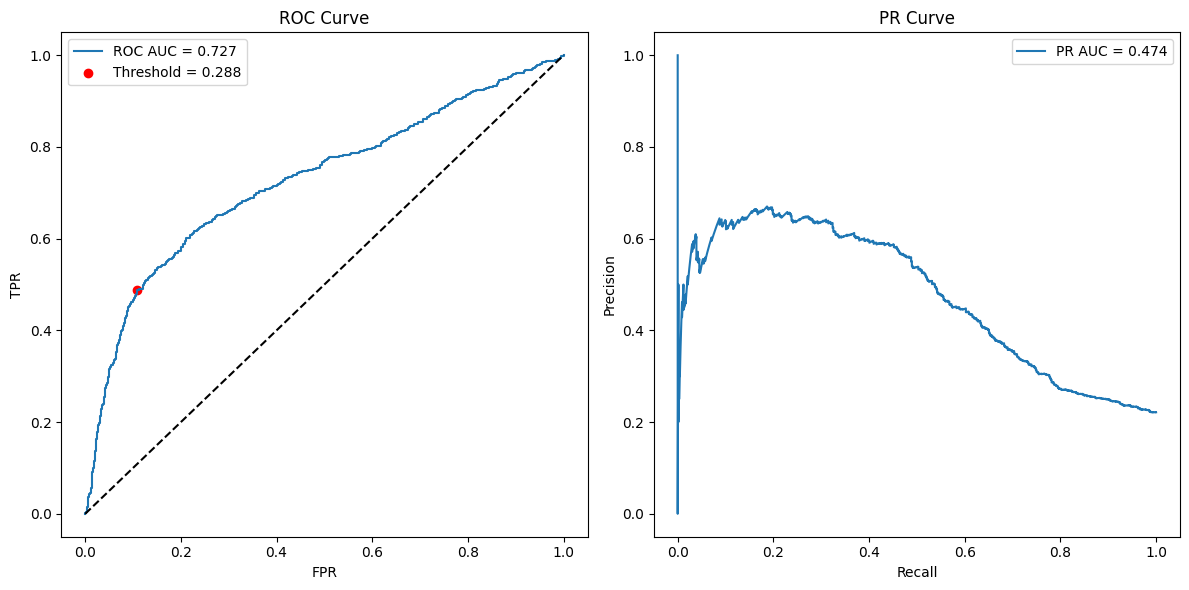

Оптимальный порог: 0.2876


In [461]:
optimal_LogReg_1 = plot_roc_pr_curves(LogReg_1, X_val_scaled, y_val)
optimal_LogReg_pca_1 = plot_roc_pr_curves(LogReg_pca_1, X_val_scaled_pca, y_val)

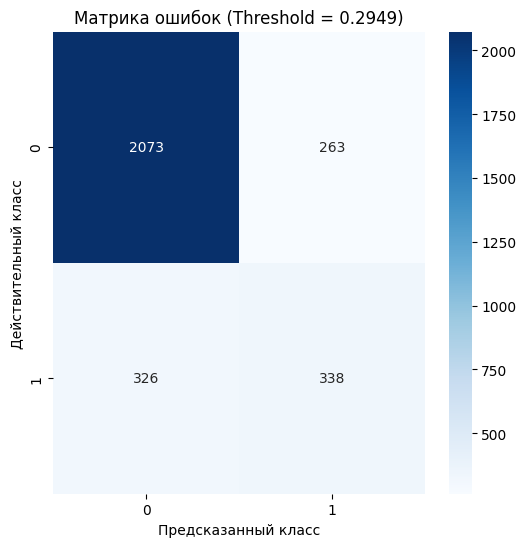


          LogReg_1 Классификатор - метрики качества
Accuracy            : 0.8037
Balanced Accuracy   : 0.6982
Precision           : 0.5624
Recall              : 0.5090
F1                  : 0.5344
ROC AUC             : 0.7306
PR AUC              : 0.4957
Threshold           : 0.2949


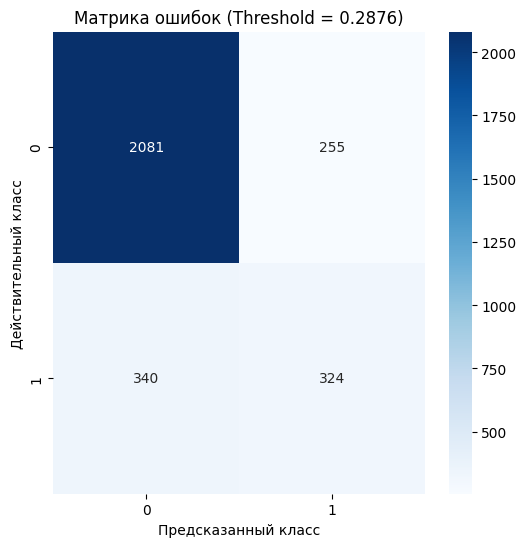


          LogReg_pca_1 Классификатор - метрики качества
Accuracy            : 0.8017
Balanced Accuracy   : 0.6894
Precision           : 0.5596
Recall              : 0.4880
F1                  : 0.5213
ROC AUC             : 0.7271
PR AUC              : 0.4736
Threshold           : 0.2876


In [462]:
metrics_LogReg_1 = evaluate_classifier(LogReg_1, X_val_scaled, y_val, model_name = 'LogReg_1 Классификатор', threshold = optimal_LogReg_1)
metrics_LogReg_pca_1 = evaluate_classifier(LogReg_pca_1, X_val_scaled_pca, y_val, model_name = 'LogReg_pca_1 Классификатор', threshold = optimal_LogReg_pca_1)

In [463]:
СompareDF = add_metrics_to_df('LogReg_1', metrics_LogReg_1, СompareDF)
СompareDF = add_metrics_to_df('LogReg_pca_1', metrics_LogReg_pca_1, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall        F1  \
0             NB  0.769667           0.711426   0.483794  0.606928  0.538410   
1         NB_pca  0.772000           0.692983   0.486702  0.551205  0.516949   
2          KNN_0  0.733000           0.666862   0.420809  0.548193  0.476128   
3      KNN_pca_0  0.721667           0.659584   0.404894  0.548193  0.465771   
4          KNN_1  0.787000           0.697225   0.518195  0.536145  0.527017   
5      KNN_pca_1  0.794000           0.697408   0.535385  0.524096  0.529680   
6          SVM_0  0.808000           0.690767   0.580000  0.480422  0.525535   
7      SVM_pca_0  0.806000           0.694873   0.571181  0.495482  0.530645   
8          SVM_1  0.805333           0.698218   0.567568  0.506024  0.535032   
9      SVM_pca_1  0.794000           0.703336   0.534226  0.540663  0.537425   
10      LogReg_0  0.803667           0.698225   0.562396  0.509036  0.534387   
11  LogReg_pca_0  0.801667           0.689395   0.559585  0.487952  0.521319   
12      LogReg_1  0.803667           0.698225   0.562396  0.509036  0.534387   
13  LogReg_pca_1  0.801667           0.689395   0.559585  0.487952  0.521319   

     ROC AUC    PR AUC  Threshold  
0   0.738629  0.485081   0.622346  
1   0.719346  0.460381   0.562912  
2   0.709754  0.416125   0.400000  
3   0.701229  0.401991   0.400000  
4   0.746651  0.502086   0.266667  
5   0.754495  0.493477   0.303050  
6   0.732955  0.514870   0.189060  
7   0.728542  0.494067   0.196265  
8   0.729463  0.513233   0.192587  
9   0.729168  0.494315   0.188591  
10  0.730489  0.495473   0.295051  
11  0.727109  0.473708   0.287607  
12  0.730602  0.495685   0.294852  
13  0.727107  0.473639   0.287617

# 7. Рассмотрим лес

In [464]:
RandForest_0 = RandomForestClassifier()
RandForest_0.fit(X_train_scaled, y_train)

RandForest_pca_0 = RandomForestClassifier()
RandForest_pca_0.fit(X_train_scaled_pca, y_train)

RandomForestClassifier()

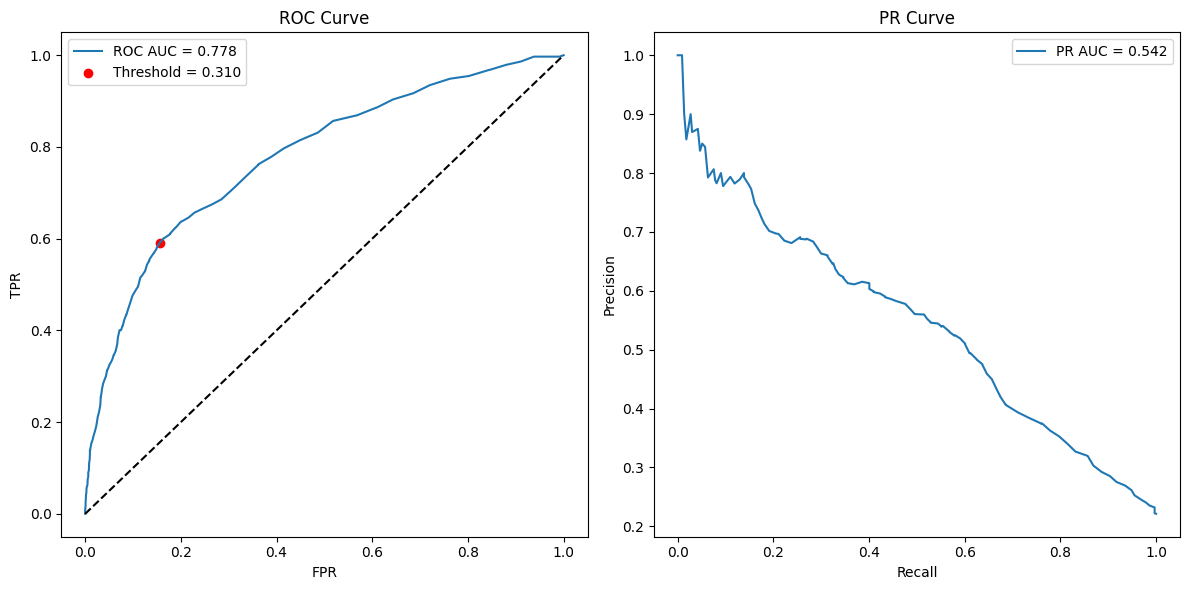

Оптимальный порог: 0.3100


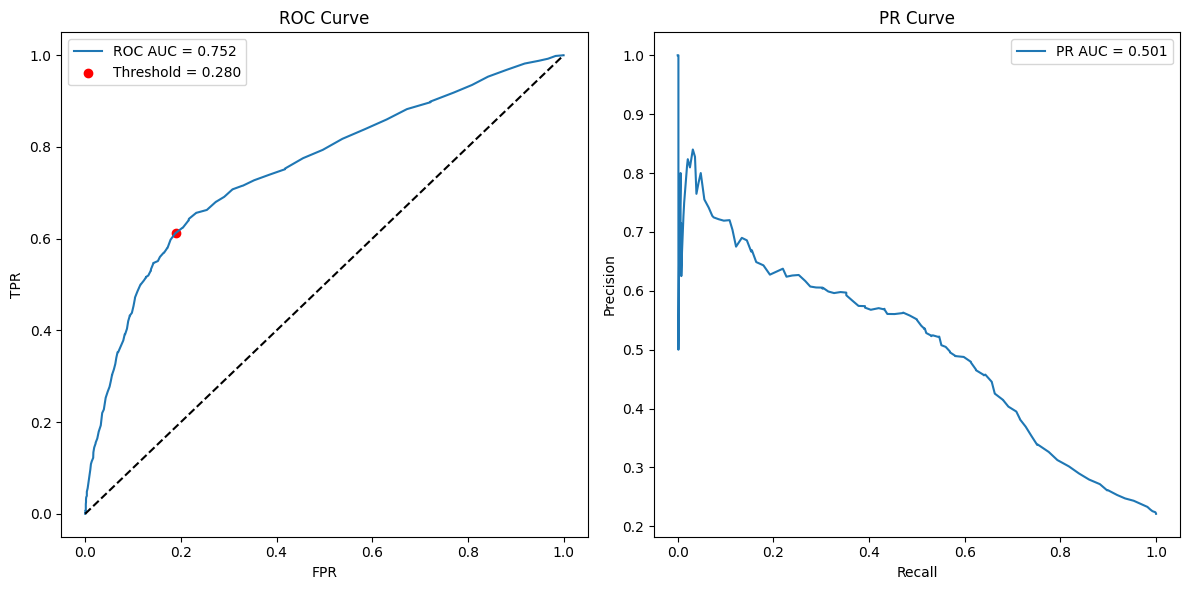

Оптимальный порог: 0.2800


In [465]:
optimal_RandForest_0 = plot_roc_pr_curves(RandForest_0, X_val_scaled, y_val)
optimal_RandForest_pca_0 = plot_roc_pr_curves(RandForest_pca_0, X_val_scaled_pca, y_val)

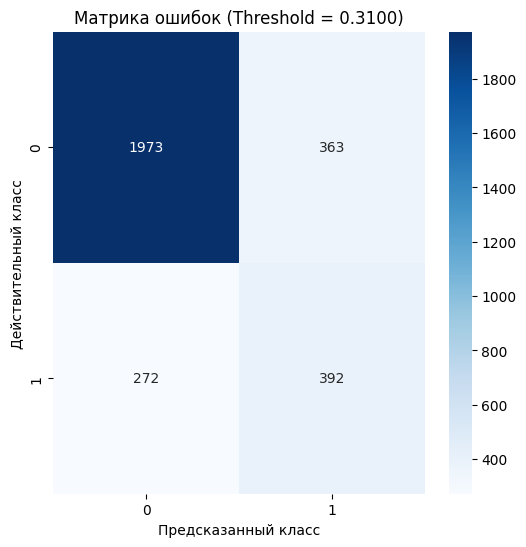


          RandForest_0 Классификатор - метрики качества
Accuracy            : 0.7883
Balanced Accuracy   : 0.7175
Precision           : 0.5192
Recall              : 0.5904
F1                  : 0.5525
ROC AUC             : 0.7775
PR AUC              : 0.5420
Threshold           : 0.3100


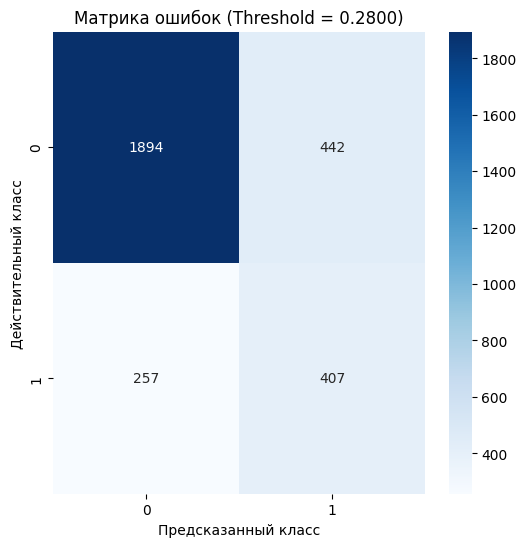


          RandForest_pca_0 Классификатор - метрики качества
Accuracy            : 0.7670
Balanced Accuracy   : 0.7119
Precision           : 0.4794
Recall              : 0.6130
F1                  : 0.5380
ROC AUC             : 0.7519
PR AUC              : 0.5009
Threshold           : 0.2800


In [466]:
metrics_RandForest_0 = evaluate_classifier(RandForest_0, X_val_scaled, y_val, model_name = 'RandForest_0 Классификатор', threshold = optimal_RandForest_0)
metrics_RandForest_pca_0 = evaluate_classifier(RandForest_pca_0, X_val_scaled_pca, y_val, model_name = 'RandForest_pca_0 Классификатор', threshold = optimal_RandForest_pca_0)

In [467]:
СompareDF = add_metrics_to_df('RandForest_0', metrics_RandForest_0, СompareDF)
СompareDF = add_metrics_to_df('RandForest_pca_0', metrics_RandForest_pca_0, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall  \
0                 NB  0.769667           0.711426   0.483794  0.606928   
1             NB_pca  0.772000           0.692983   0.486702  0.551205   
2              KNN_0  0.733000           0.666862   0.420809  0.548193   
3          KNN_pca_0  0.721667           0.659584   0.404894  0.548193   
4              KNN_1  0.787000           0.697225   0.518195  0.536145   
5          KNN_pca_1  0.794000           0.697408   0.535385  0.524096   
6              SVM_0  0.808000           0.690767   0.580000  0.480422   
7          SVM_pca_0  0.806000           0.694873   0.571181  0.495482   
8              SVM_1  0.805333           0.698218   0.567568  0.506024   
9          SVM_pca_1  0.794000           0.703336   0.534226  0.540663   
10          LogReg_0  0.803667           0.698225   0.562396  0.509036   
11      LogReg_pca_0  0.801667           0.689395   0.559585  0.487952   
12          LogReg_1  0.803667           0.698225   0.562396  0.509036   
13      LogReg_pca_1  0.801667           0.689395   0.559585  0.487952   
14      RandForest_0  0.788333           0.717484   0.519205  0.590361   
15  RandForest_pca_0  0.767000           0.711870   0.479388  0.612952   

          F1   ROC AUC    PR AUC  Threshold  
0   0.538410  0.738629  0.485081   0.622346  
1   0.516949  0.719346  0.460381   0.562912  
2   0.476128  0.709754  0.416125   0.400000  
3   0.465771  0.701229  0.401991   0.400000  
4   0.527017  0.746651  0.502086   0.266667  
5   0.529680  0.754495  0.493477   0.303050  
6   0.525535  0.732955  0.514870   0.189060  
7   0.530645  0.728542  0.494067   0.196265  
8   0.535032  0.729463  0.513233   0.192587  
9   0.537425  0.729168  0.494315   0.188591  
10  0.534387  0.730489  0.495473   0.295051  
11  0.521319  0.727109  0.473708   0.287607  
12  0.534387  0.730602  0.495685   0.294852  
13  0.521319  0.727107  0.473639   0.287617  
14  0.552502  0.777507  0.542008   0.310000  
15  0.538004  0.751931  0.500927   0.280000

### Лес уже побеждает другие модели. Но мы все равно подберем гиперпарметры.

In [468]:
parameters = {'n_estimators': np.arange(10, 550, 30),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 100),
              'max_features': ['sqrt', 'log2'],
              'bootstrap': [True],
              'max_samples': np.arange(0.1, 1, 0.3)}

RandForest_1_params = find_best_params(RandomForestClassifier(), X_train_scaled, y_train, parameters, 'Params/RandForest_1_params.json', iters = 190)
RandForest_pca_1_params = find_best_params(RandomForestClassifier(), X_train_scaled_pca, y_train, parameters, 'Params/RandForest_pca_1_params.json', iters = 190)
print(RandForest_1_params)
print(RandForest_pca_1_params)

{'n_estimators': 250, 'max_samples': 0.7000000000000001, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
{'n_estimators': 520, 'max_samples': 0.4, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'log_loss', 'bootstrap': True}


In [469]:
RandForest_1 = RandomForestClassifier(**RandForest_1_params)
RandForest_1.fit(X_train_scaled, y_train)

RandForest_pca_1 = RandomForestClassifier(**RandForest_pca_1_params)
RandForest_pca_1.fit(X_train_scaled_pca, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=14, max_samples=0.4,
                       n_estimators=520)

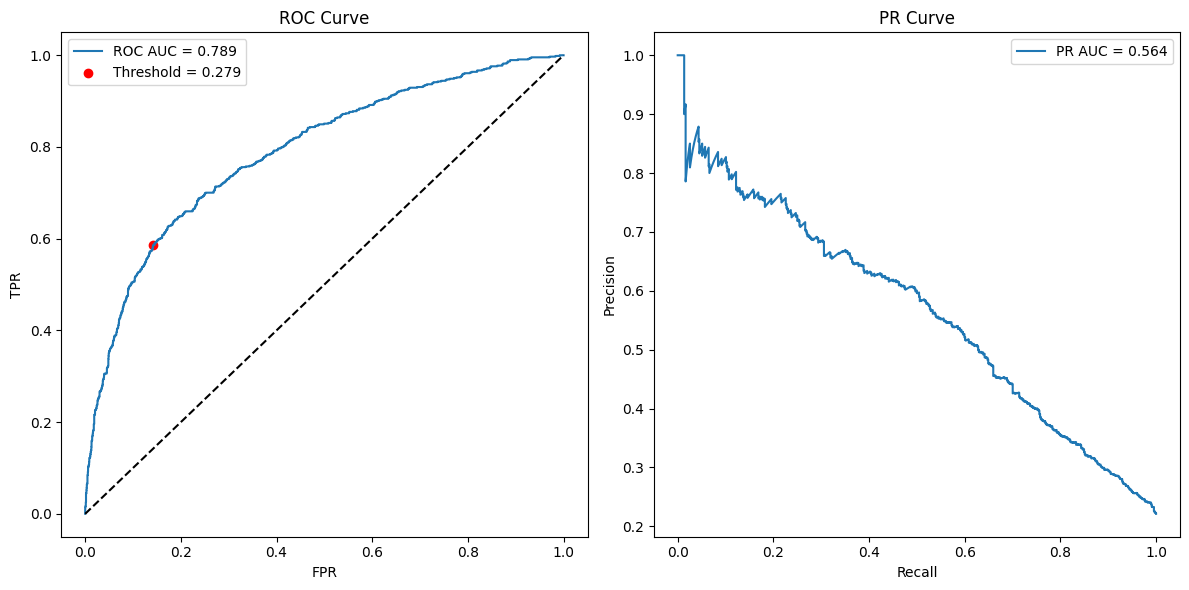

Оптимальный порог: 0.2787


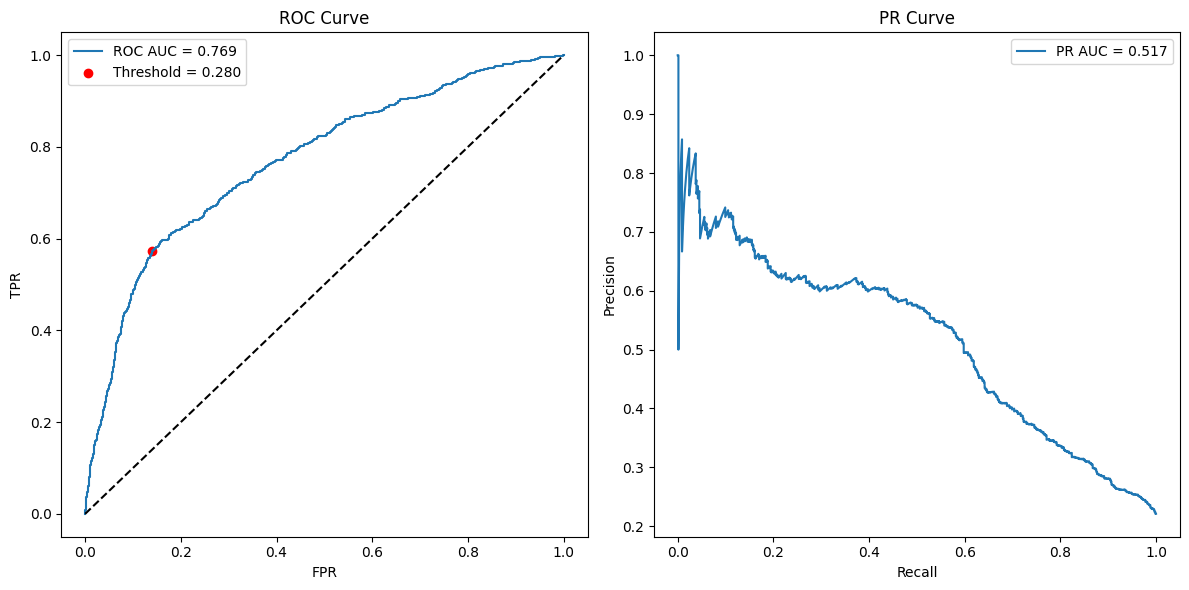

Оптимальный порог: 0.2803


In [470]:
optimal_RandForest_1 = plot_roc_pr_curves(RandForest_1, X_val_scaled, y_val)
optimal_RandForest_pca_1 = plot_roc_pr_curves(RandForest_pca_1, X_val_scaled_pca, y_val)

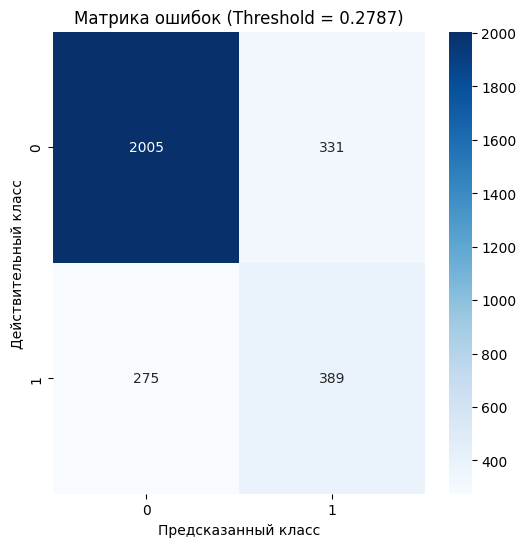


          RandForest_1 Классификатор - метрики качества
Accuracy            : 0.7980
Balanced Accuracy   : 0.7221
Precision           : 0.5403
Recall              : 0.5858
F1                  : 0.5621
ROC AUC             : 0.7892
PR AUC              : 0.5642
Threshold           : 0.2787


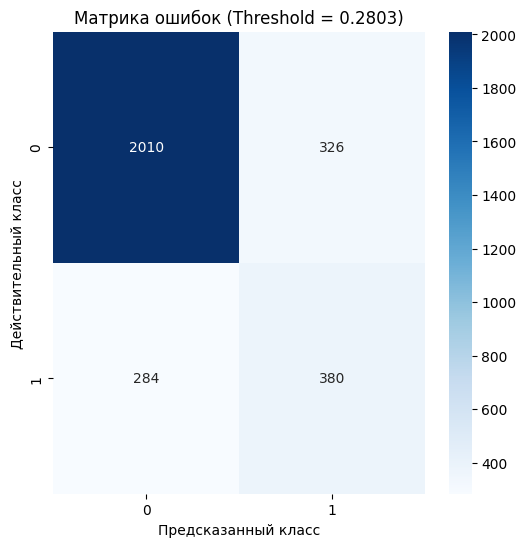


          RandForest_pca_1 Классификатор - метрики качества
Accuracy            : 0.7967
Balanced Accuracy   : 0.7164
Precision           : 0.5382
Recall              : 0.5723
F1                  : 0.5547
ROC AUC             : 0.7690
PR AUC              : 0.5166
Threshold           : 0.2803


In [471]:
metrics_RandForest_1 = evaluate_classifier(RandForest_1, X_val_scaled, y_val, model_name = 'RandForest_1 Классификатор', threshold = optimal_RandForest_1)
metrics_RandForest_pca_1 = evaluate_classifier(RandForest_pca_1, X_val_scaled_pca, y_val, model_name = 'RandForest_pca_1 Классификатор', threshold = optimal_RandForest_pca_1)

In [472]:
СompareDF = add_metrics_to_df('RandForest_1', metrics_RandForest_1, СompareDF)
СompareDF = add_metrics_to_df('RandForest_pca_1', metrics_RandForest_pca_1, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall  \
0                 NB  0.769667           0.711426   0.483794  0.606928   
1             NB_pca  0.772000           0.692983   0.486702  0.551205   
2              KNN_0  0.733000           0.666862   0.420809  0.548193   
3          KNN_pca_0  0.721667           0.659584   0.404894  0.548193   
4              KNN_1  0.787000           0.697225   0.518195  0.536145   
5          KNN_pca_1  0.794000           0.697408   0.535385  0.524096   
6              SVM_0  0.808000           0.690767   0.580000  0.480422   
7          SVM_pca_0  0.806000           0.694873   0.571181  0.495482   
8              SVM_1  0.805333           0.698218   0.567568  0.506024   
9          SVM_pca_1  0.794000           0.703336   0.534226  0.540663   
10          LogReg_0  0.803667           0.698225   0.562396  0.509036   
11      LogReg_pca_0  0.801667           0.689395   0.559585  0.487952   
12          LogReg_1  0.803667           0.698225   0.562396  0.509036   
13      LogReg_pca_1  0.801667           0.689395   0.559585  0.487952   
14      RandForest_0  0.788333           0.717484   0.519205  0.590361   
15  RandForest_pca_0  0.767000           0.711870   0.479388  0.612952   
16      RandForest_1  0.798000           0.722074   0.540278  0.585843   
17  RandForest_pca_1  0.796667           0.716367   0.538244  0.572289   

          F1   ROC AUC    PR AUC  Threshold  
0   0.538410  0.738629  0.485081   0.622346  
1   0.516949  0.719346  0.460381   0.562912  
2   0.476128  0.709754  0.416125   0.400000  
3   0.465771  0.701229  0.401991   0.400000  
4   0.527017  0.746651  0.502086   0.266667  
5   0.529680  0.754495  0.493477   0.303050  
6   0.525535  0.732955  0.514870   0.189060  
7   0.530645  0.728542  0.494067   0.196265  
8   0.535032  0.729463  0.513233   0.192587  
9   0.537425  0.729168  0.494315   0.188591  
10  0.534387  0.730489  0.495473   0.295051  
11  0.521319  0.727109  0.473708   0.287607  
12  0.534387  0.730602  0.495685   0.294852  
13  0.521319  0.727107  0.473639   0.287617  
14  0.552502  0.777507  0.542008   0.310000  
15  0.538004  0.751931  0.500927   0.280000  
16  0.562139  0.789232  0.564241   0.278669  
17  0.554745  0.769017  0.516585   0.280266

# 8. И, наконец, Градиентный Бустинг

### Используем CatBoostClassifier, так как категориальных данных нет

In [473]:
CatBoost_0 = CatBoostClassifier()
CatBoost_0.fit(X_train_scaled, y_train)

CatBoost_pca_0 = CatBoostClassifier()
CatBoost_pca_0.fit(X_train_scaled_pca, y_train)

Learning rate set to 0.040021
0:	learn: 0.6702448	total: 18.4ms	remaining: 18.4s
1:	learn: 0.6494500	total: 33.9ms	remaining: 16.9s
2:	learn: 0.6308619	total: 51.1ms	remaining: 17s
3:	learn: 0.6133940	total: 65.7ms	remaining: 16.4s
4:	learn: 0.5985187	total: 78.6ms	remaining: 15.7s
5:	learn: 0.5840176	total: 92.3ms	remaining: 15.3s
6:	learn: 0.5711797	total: 106ms	remaining: 15s
7:	learn: 0.5595734	total: 120ms	remaining: 14.9s
8:	learn: 0.5486794	total: 134ms	remaining: 14.8s
9:	learn: 0.5386700	total: 148ms	remaining: 14.7s
10:	learn: 0.5298870	total: 160ms	remaining: 14.4s
11:	learn: 0.5219157	total: 173ms	remaining: 14.2s
12:	learn: 0.5142620	total: 185ms	remaining: 14.1s
13:	learn: 0.5072891	total: 199ms	remaining: 14s
14:	learn: 0.5012064	total: 212ms	remaining: 13.9s
15:	learn: 0.4954550	total: 225ms	remaining: 13.9s
16:	learn: 0.4901819	total: 238ms	remaining: 13.7s
17:	learn: 0.4854635	total: 250ms	remaining: 13.6s
18:	learn: 0.4809681	total: 262ms	remaining: 13.5s
19:	learn: 

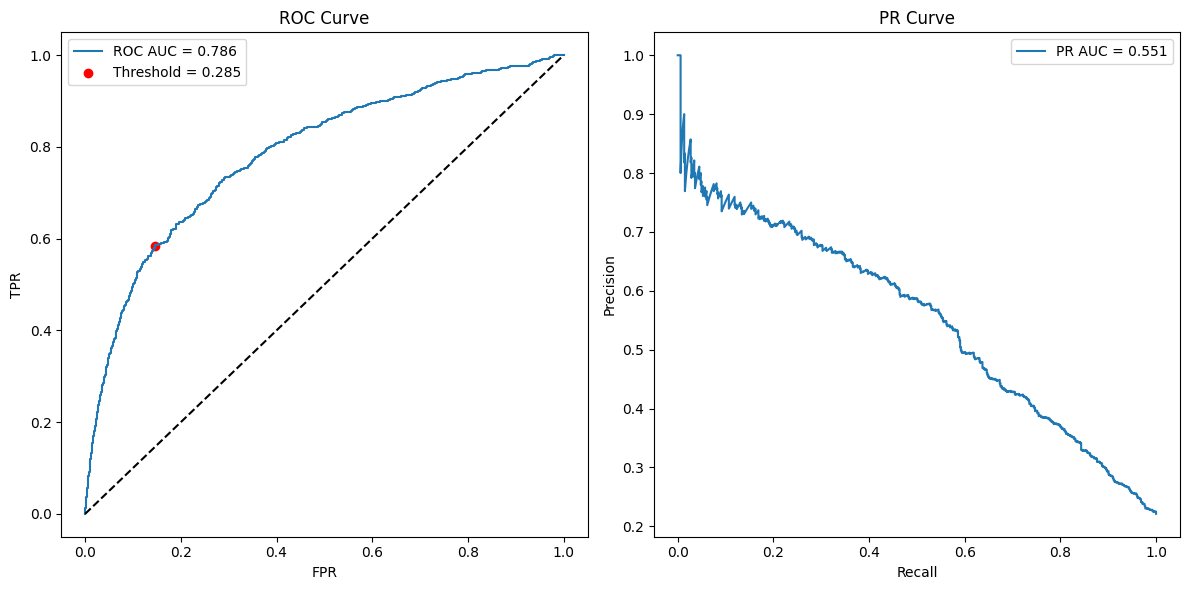

Оптимальный порог: 0.2854


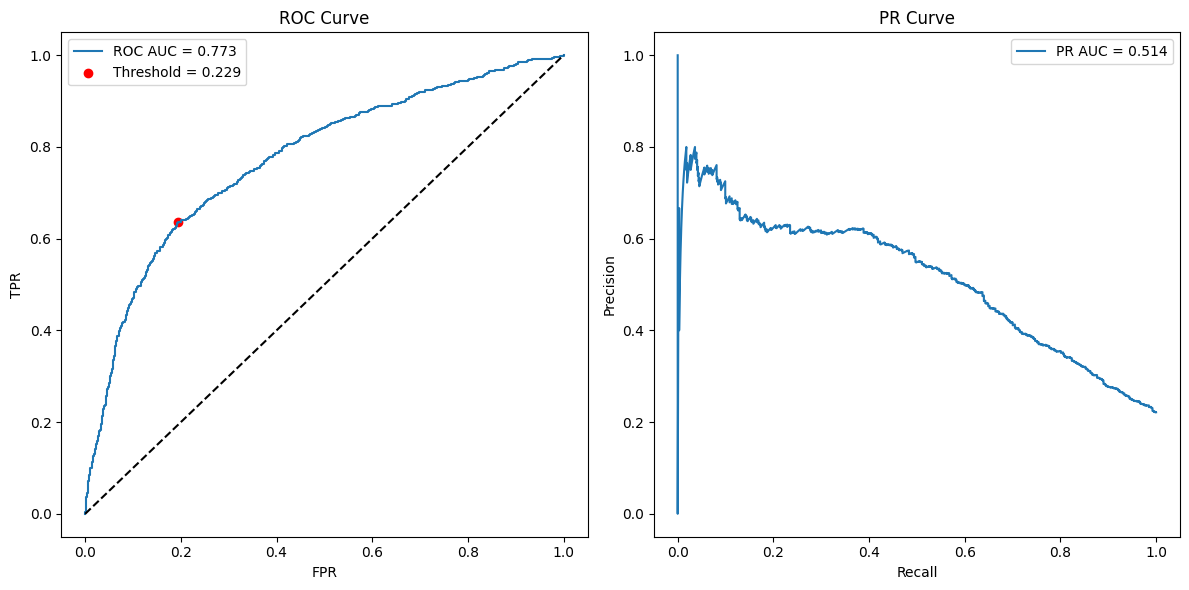

Оптимальный порог: 0.2291


In [474]:
optimal_CatBoost_0 = plot_roc_pr_curves(CatBoost_0, X_val_scaled, y_val)
optimal_CatBoost_pca_0 = plot_roc_pr_curves(CatBoost_pca_0, X_val_scaled_pca, y_val)

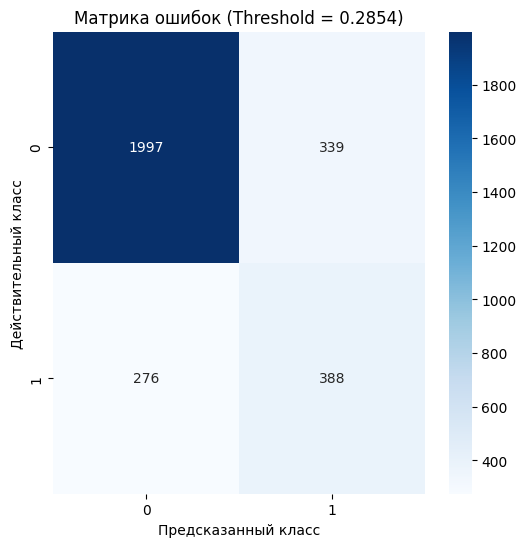


          CatBoost_0 Классификатор - метрики качества
Accuracy            : 0.7950
Balanced Accuracy   : 0.7196
Precision           : 0.5337
Recall              : 0.5843
F1                  : 0.5579
ROC AUC             : 0.7859
PR AUC              : 0.5506
Threshold           : 0.2854


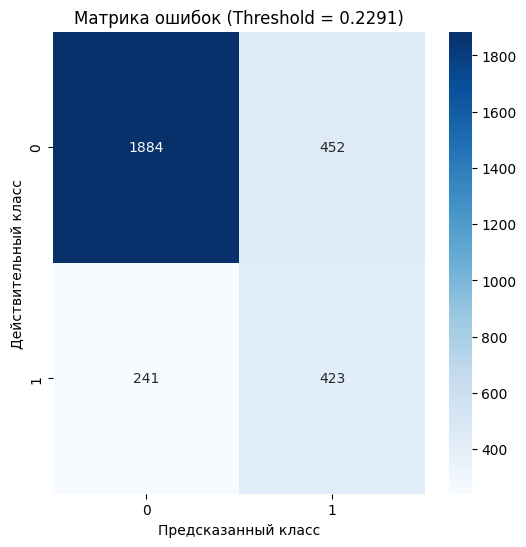


          CatBoost_pca_0 Классификатор - метрики качества
Accuracy            : 0.7690
Balanced Accuracy   : 0.7218
Precision           : 0.4834
Recall              : 0.6370
F1                  : 0.5497
ROC AUC             : 0.7727
PR AUC              : 0.5140
Threshold           : 0.2291


In [475]:
metrics_CatBoost_0 = evaluate_classifier(CatBoost_0, X_val_scaled, y_val, model_name = 'CatBoost_0 Классификатор', threshold = optimal_CatBoost_0)
metrics_CatBoost_pca_0 = evaluate_classifier(CatBoost_pca_0, X_val_scaled_pca, y_val, model_name = 'CatBoost_pca_0 Классификатор', threshold = optimal_CatBoost_pca_0)

In [476]:
СompareDF = add_metrics_to_df('CatBoost_0', metrics_CatBoost_0, СompareDF)
СompareDF = add_metrics_to_df('CatBoost_pca_0', metrics_CatBoost_pca_0, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall  \
0                 NB  0.769667           0.711426   0.483794  0.606928   
1             NB_pca  0.772000           0.692983   0.486702  0.551205   
2              KNN_0  0.733000           0.666862   0.420809  0.548193   
3          KNN_pca_0  0.721667           0.659584   0.404894  0.548193   
4              KNN_1  0.787000           0.697225   0.518195  0.536145   
5          KNN_pca_1  0.794000           0.697408   0.535385  0.524096   
6              SVM_0  0.808000           0.690767   0.580000  0.480422   
7          SVM_pca_0  0.806000           0.694873   0.571181  0.495482   
8              SVM_1  0.805333           0.698218   0.567568  0.506024   
9          SVM_pca_1  0.794000           0.703336   0.534226  0.540663   
10          LogReg_0  0.803667           0.698225   0.562396  0.509036   
11      LogReg_pca_0  0.801667           0.689395   0.559585  0.487952   
12          LogReg_1  0.803667           0.698225   0.562396  0.509036   
13      LogReg_pca_1  0.801667           0.689395   0.559585  0.487952   
14      RandForest_0  0.788333           0.717484   0.519205  0.590361   
15  RandForest_pca_0  0.767000           0.711870   0.479388  0.612952   
16      RandForest_1  0.798000           0.722074   0.540278  0.585843   
17  RandForest_pca_1  0.796667           0.716367   0.538244  0.572289   
18        CatBoost_0  0.795000           0.719609   0.533700  0.584337   
19    CatBoost_pca_0  0.769000           0.721778   0.483429  0.637048   

          F1   ROC AUC    PR AUC  Threshold  
0   0.538410  0.738629  0.485081   0.622346  
1   0.516949  0.719346  0.460381   0.562912  
2   0.476128  0.709754  0.416125   0.400000  
3   0.465771  0.701229  0.401991   0.400000  
4   0.527017  0.746651  0.502086   0.266667  
5   0.529680  0.754495  0.493477   0.303050  
6   0.525535  0.732955  0.514870   0.189060  
7   0.530645  0.728542  0.494067   0.196265  
8   0.535032  0.729463  0.513233   0.192587  
9   0.537425  0.729168  0.494315   0.188591  
10  0.534387  0.730489  0.495473   0.295051  
11  0.521319  0.727109  0.473708   0.287607  
12  0.534387  0.730602  0.495685   0.294852  
13  0.521319  0.727107  0.473639   0.287617  
14  0.552502  0.777507  0.542008   0.310000  
15  0.538004  0.751931  0.500927   0.280000  
16  0.562139  0.789232  0.564241   0.278669  
17  0.554745  0.769017  0.516585   0.280266  
18  0.557872  0.785938  0.550557   0.285353  
19  0.549708  0.772662  0.514017   0.229117

## Получилось хуже леса (до подбора ГП)

In [477]:
parameters = {
    'iterations': np.arange(100, 501, 100),
    'depth': np.arange(4, 11),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'l2_leaf_reg': np.logspace(-2, 2, 10),
    'bagging_temperature': np.linspace(0, 1, 11),
    'border_count': np.arange(32, 256, 32)
}

CatBoost_1_params = find_best_params(CatBoostClassifier(), X_train_scaled, y_train, parameters, 'Params/CatBoost_1_params.json', iters = 50)
CatBoost_pca_1_params = find_best_params(CatBoostClassifier(), X_train_scaled_pca, y_train, parameters, 'Params/CatBoost_pca_1_params.json', iters = 50)

print(CatBoost_1_params)
print(CatBoost_pca_1_params)

{'learning_rate': 0.06999999999999999, 'l2_leaf_reg': 100.0, 'iterations': 400, 'depth': 6, 'border_count': 224, 'bagging_temperature': 0.2}
{'learning_rate': 0.22999999999999998, 'l2_leaf_reg': 12.915496650148826, 'iterations': 100, 'depth': 6, 'border_count': 160, 'bagging_temperature': 0.6000000000000001}


In [478]:
CatBoost_1 = CatBoostClassifier(**CatBoost_1_params)
CatBoost_1.fit(X_train_scaled, y_train)

CatBoost_pca_1 = CatBoostClassifier(**CatBoost_pca_1_params)
CatBoost_pca_1.fit(X_train_scaled_pca, y_train)

0:	learn: 0.6553367	total: 20.9ms	remaining: 8.34s
1:	learn: 0.6225506	total: 37.2ms	remaining: 7.41s
2:	learn: 0.5954987	total: 49.9ms	remaining: 6.6s
3:	learn: 0.5716623	total: 63.3ms	remaining: 6.26s
4:	learn: 0.5521050	total: 76.2ms	remaining: 6.02s
5:	learn: 0.5343450	total: 90.2ms	remaining: 5.93s
6:	learn: 0.5199766	total: 104ms	remaining: 5.83s
7:	learn: 0.5079802	total: 118ms	remaining: 5.76s
8:	learn: 0.4974654	total: 131ms	remaining: 5.71s
9:	learn: 0.4884010	total: 146ms	remaining: 5.69s
10:	learn: 0.4808621	total: 160ms	remaining: 5.65s
11:	learn: 0.4745025	total: 174ms	remaining: 5.63s
12:	learn: 0.4687900	total: 187ms	remaining: 5.57s
13:	learn: 0.4636298	total: 200ms	remaining: 5.52s
14:	learn: 0.4594098	total: 213ms	remaining: 5.46s
15:	learn: 0.4558009	total: 226ms	remaining: 5.43s
16:	learn: 0.4526243	total: 240ms	remaining: 5.41s
17:	learn: 0.4497091	total: 253ms	remaining: 5.37s
18:	learn: 0.4473430	total: 267ms	remaining: 5.35s
19:	learn: 0.4453239	total: 281ms	re

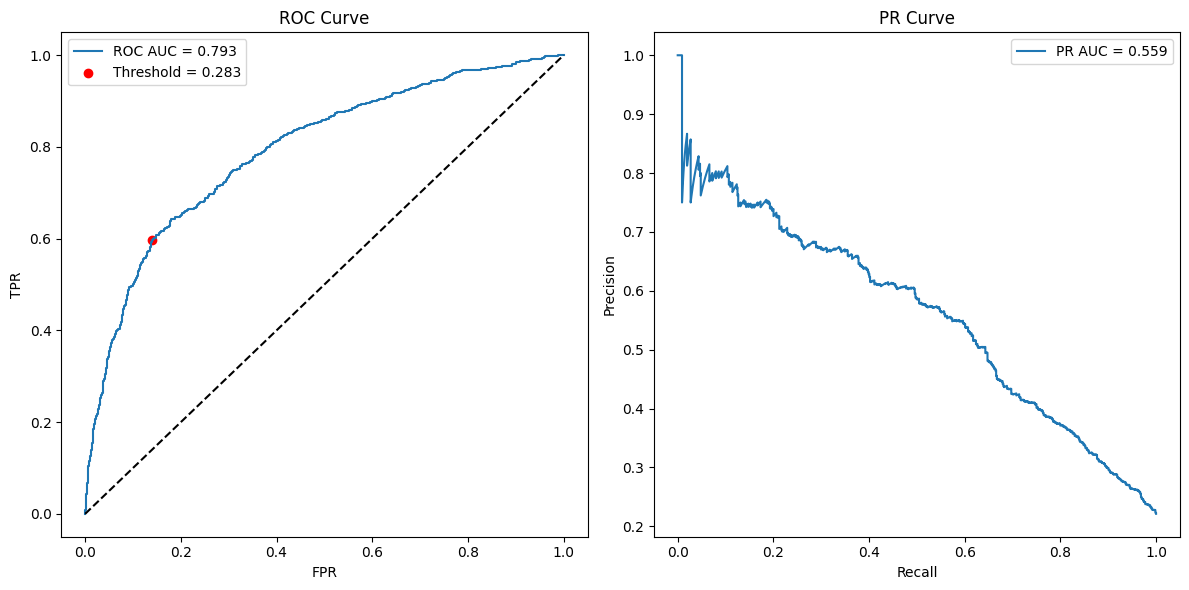

Оптимальный порог: 0.2826


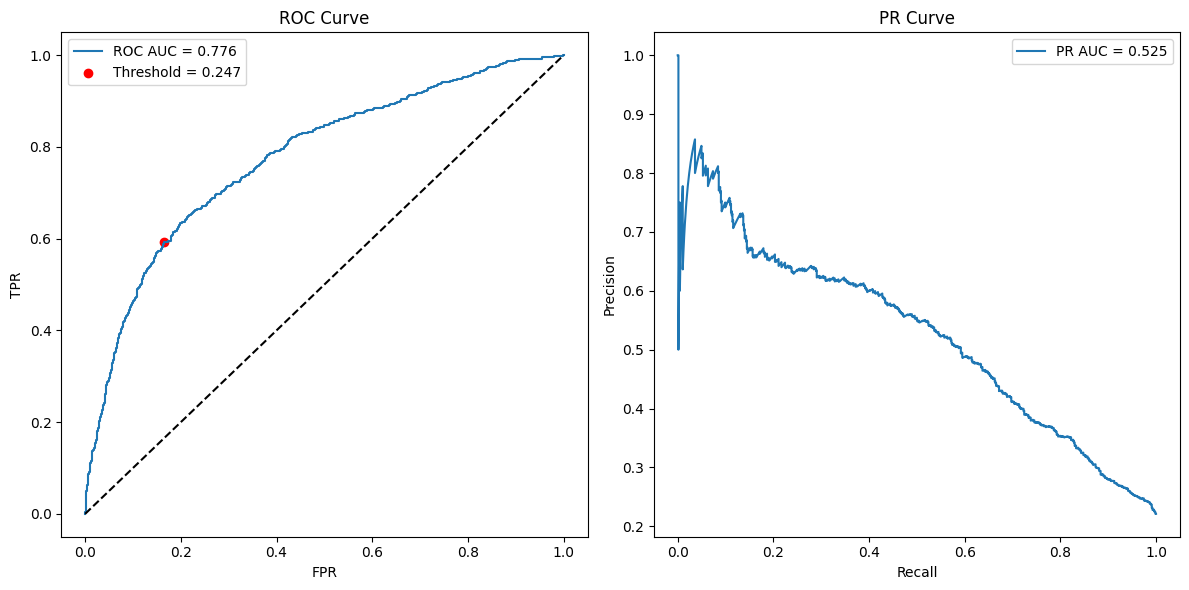

Оптимальный порог: 0.2471


In [479]:
optimal_CatBoost_1 = plot_roc_pr_curves(CatBoost_1, X_val_scaled, y_val)
optimal_CatBoost_pca_1 = plot_roc_pr_curves(CatBoost_pca_1, X_val_scaled_pca, y_val)

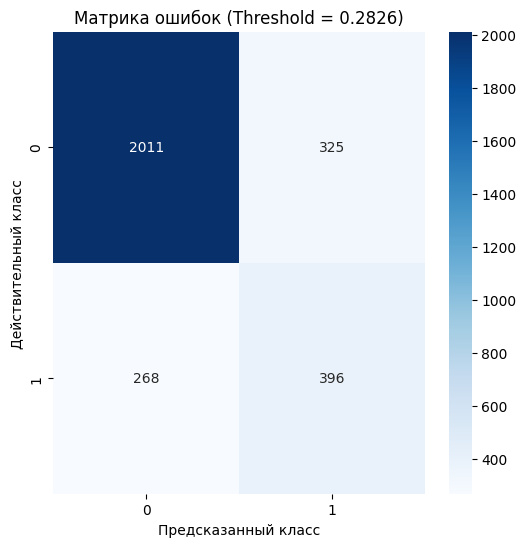


          CatBoost_1 Классификатор - метрики качества
Accuracy            : 0.8023
Balanced Accuracy   : 0.7286
Precision           : 0.5492
Recall              : 0.5964
F1                  : 0.5718
ROC AUC             : 0.7927
PR AUC              : 0.5591
Threshold           : 0.2826


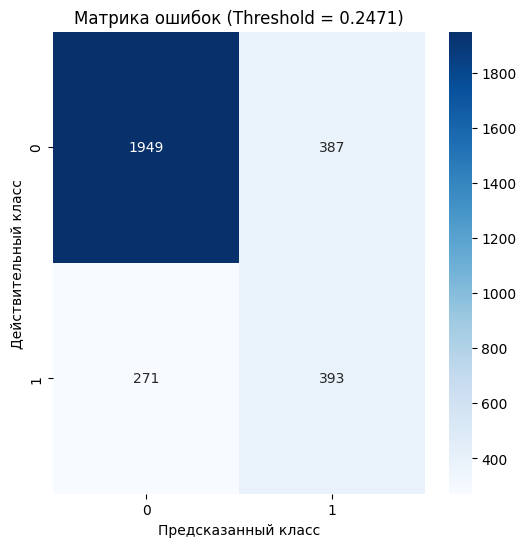


          CatBoost_pca_1 Классификатор - метрики качества
Accuracy            : 0.7807
Balanced Accuracy   : 0.7131
Precision           : 0.5038
Recall              : 0.5919
F1                  : 0.5443
ROC AUC             : 0.7757
PR AUC              : 0.5252
Threshold           : 0.2471


In [480]:
metrics_CatBoost_1 = evaluate_classifier(CatBoost_1, X_val_scaled, y_val, model_name = 'CatBoost_1 Классификатор', threshold = optimal_CatBoost_1)
metrics_CatBoost_pca_1 = evaluate_classifier(CatBoost_pca_1, X_val_scaled_pca, y_val, model_name = 'CatBoost_pca_1 Классификатор', threshold = optimal_CatBoost_pca_1)

In [481]:
СompareDF = add_metrics_to_df('CatBoost_1', metrics_CatBoost_1, СompareDF)
СompareDF = add_metrics_to_df('CatBoost_pca_1', metrics_CatBoost_pca_1, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall  \
0                 NB  0.769667           0.711426   0.483794  0.606928   
1             NB_pca  0.772000           0.692983   0.486702  0.551205   
2              KNN_0  0.733000           0.666862   0.420809  0.548193   
3          KNN_pca_0  0.721667           0.659584   0.404894  0.548193   
4              KNN_1  0.787000           0.697225   0.518195  0.536145   
5          KNN_pca_1  0.794000           0.697408   0.535385  0.524096   
6              SVM_0  0.808000           0.690767   0.580000  0.480422   
7          SVM_pca_0  0.806000           0.694873   0.571181  0.495482   
8              SVM_1  0.805333           0.698218   0.567568  0.506024   
9          SVM_pca_1  0.794000           0.703336   0.534226  0.540663   
10          LogReg_0  0.803667           0.698225   0.562396  0.509036   
11      LogReg_pca_0  0.801667           0.689395   0.559585  0.487952   
12          LogReg_1  0.803667           0.698225   0.562396  0.509036   
13      LogReg_pca_1  0.801667           0.689395   0.559585  0.487952   
14      RandForest_0  0.788333           0.717484   0.519205  0.590361   
15  RandForest_pca_0  0.767000           0.711870   0.479388  0.612952   
16      RandForest_1  0.798000           0.722074   0.540278  0.585843   
17  RandForest_pca_1  0.796667           0.716367   0.538244  0.572289   
18        CatBoost_0  0.795000           0.719609   0.533700  0.584337   
19    CatBoost_pca_0  0.769000           0.721778   0.483429  0.637048   
20        CatBoost_1  0.802333           0.728629   0.549237  0.596386   
21    CatBoost_pca_1  0.780667           0.713100   0.503846  0.591867   

          F1   ROC AUC    PR AUC  Threshold  
0   0.538410  0.738629  0.485081   0.622346  
1   0.516949  0.719346  0.460381   0.562912  
2   0.476128  0.709754  0.416125   0.400000  
3   0.465771  0.701229  0.401991   0.400000  
4   0.527017  0.746651  0.502086   0.266667  
5   0.529680  0.754495  0.493477   0.303050  
6   0.525535  0.732955  0.514870   0.189060  
7   0.530645  0.728542  0.494067   0.196265  
8   0.535032  0.729463  0.513233   0.192587  
9   0.537425  0.729168  0.494315   0.188591  
10  0.534387  0.730489  0.495473   0.295051  
11  0.521319  0.727109  0.473708   0.287607  
12  0.534387  0.730602  0.495685   0.294852  
13  0.521319  0.727107  0.473639   0.287617  
14  0.552502  0.777507  0.542008   0.310000  
15  0.538004  0.751931  0.500927   0.280000  
16  0.562139  0.789232  0.564241   0.278669  
17  0.554745  0.769017  0.516585   0.280266  
18  0.557872  0.785938  0.550557   0.285353  
19  0.549708  0.772662  0.514017   0.229117  
20  0.571841  0.792731  0.559098   0.282588  
21  0.544321  0.775689  0.525227   0.247099

### Выигрывает CatBoost с подобранными параметрами на датасете без PCA

In [482]:
best_models_df = find_best_models(СompareDF)
best_models_df

Best Model     Value
Accuracy                    SVM_0  0.808000
Balanced Accuracy      CatBoost_1  0.728629
Precision                   SVM_0  0.580000
Recall             CatBoost_pca_0  0.637048
F1                     CatBoost_1  0.571841
ROC AUC                CatBoost_1  0.792731
PR AUC               RandForest_1  0.564241

# 9. Feature Engineering и Stacking

### Добавим фичи и объединим две лучшие модели

In [483]:
X['UTILIZATION_RATIO_1'] = X['BILL_AMT1'] / (X['LIMIT_BAL'] + 10 ** (-6))
X['HAS_DELAY'] = (X[['PAY_0', 'PAY_2', 'PAY_3']] > 0).any(axis = 1).astype(int)

pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
X['MAX_DELAY'] = X[pay_cols].max(axis = 1)
X['MEAN_DELAY'] = X[pay_cols].mean(axis = 1)

X['BILL_AMT_DIFF'] = X['BILL_AMT1'] - X['BILL_AMT6']

In [484]:
X_train, X_val, X_test = X.iloc[idx_train], X.iloc[idx_val], X.iloc[idx_test]
y_train, y_val, y_test = y.iloc[idx_train], y.iloc[idx_val], y.iloc[idx_test]

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [485]:
parameters_boosting = {
    'iterations': np.arange(100, 501, 100),
    'depth': np.arange(4, 11),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'l2_leaf_reg': np.logspace(-2, 2, 10),
    'bagging_temperature': np.linspace(0, 1, 11),
    'border_count': np.arange(32, 256, 32)
}

parameters_forest = {'n_estimators': np.arange(10, 550, 30),
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 100),
              'max_features': ['sqrt', 'log2'],
              'bootstrap': [True],
              'max_samples': np.arange(0.1, 1, 0.3)}

CatBoost_2_params = find_best_params(CatBoostClassifier(), X_train_scaled, y_train, parameters_boosting, 'Params/CatBoost_2_params.json', iters = 50)
RandForest_2_params = find_best_params(RandomForestClassifier(), X_train_scaled, y_train, parameters_forest, 'Params/RandForest_2_params.json', iters = 190)

In [486]:
print(RandForest_2_params)
print(CatBoost_2_params)

{'n_estimators': 400, 'max_samples': 0.7000000000000001, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
{'learning_rate': 0.01, 'l2_leaf_reg': 0.027825594022071243, 'iterations': 400, 'depth': 8, 'border_count': 32, 'bagging_temperature': 0.7000000000000001}


In [487]:
CatBoost_2 = CatBoostClassifier(**CatBoost_2_params)
CatBoost_2.fit(X_train_scaled, y_train)

RandForest_2 = RandomForestClassifier(**RandForest_2_params)
RandForest_2.fit(X_train_scaled, y_train)

0:	learn: 0.6871358	total: 23.1ms	remaining: 9.23s
1:	learn: 0.6812013	total: 39.3ms	remaining: 7.83s
2:	learn: 0.6754251	total: 55.4ms	remaining: 7.33s
3:	learn: 0.6698880	total: 71.1ms	remaining: 7.04s
4:	learn: 0.6645078	total: 86.7ms	remaining: 6.85s
5:	learn: 0.6593017	total: 102ms	remaining: 6.67s
6:	learn: 0.6540331	total: 117ms	remaining: 6.55s
7:	learn: 0.6488323	total: 132ms	remaining: 6.49s
8:	learn: 0.6437160	total: 147ms	remaining: 6.38s
9:	learn: 0.6388591	total: 162ms	remaining: 6.33s
10:	learn: 0.6341158	total: 177ms	remaining: 6.26s
11:	learn: 0.6294463	total: 192ms	remaining: 6.22s
12:	learn: 0.6248165	total: 208ms	remaining: 6.18s
13:	learn: 0.6203421	total: 223ms	remaining: 6.15s
14:	learn: 0.6158874	total: 239ms	remaining: 6.13s
15:	learn: 0.6116752	total: 254ms	remaining: 6.1s
16:	learn: 0.6076594	total: 268ms	remaining: 6.04s
17:	learn: 0.6036259	total: 284ms	remaining: 6.02s
18:	learn: 0.5996971	total: 299ms	remaining: 6s
19:	learn: 0.5957630	total: 314ms	remain

RandomForestClassifier(max_depth=10, max_samples=0.7000000000000001,
                       n_estimators=400)

In [488]:
names = X.columns

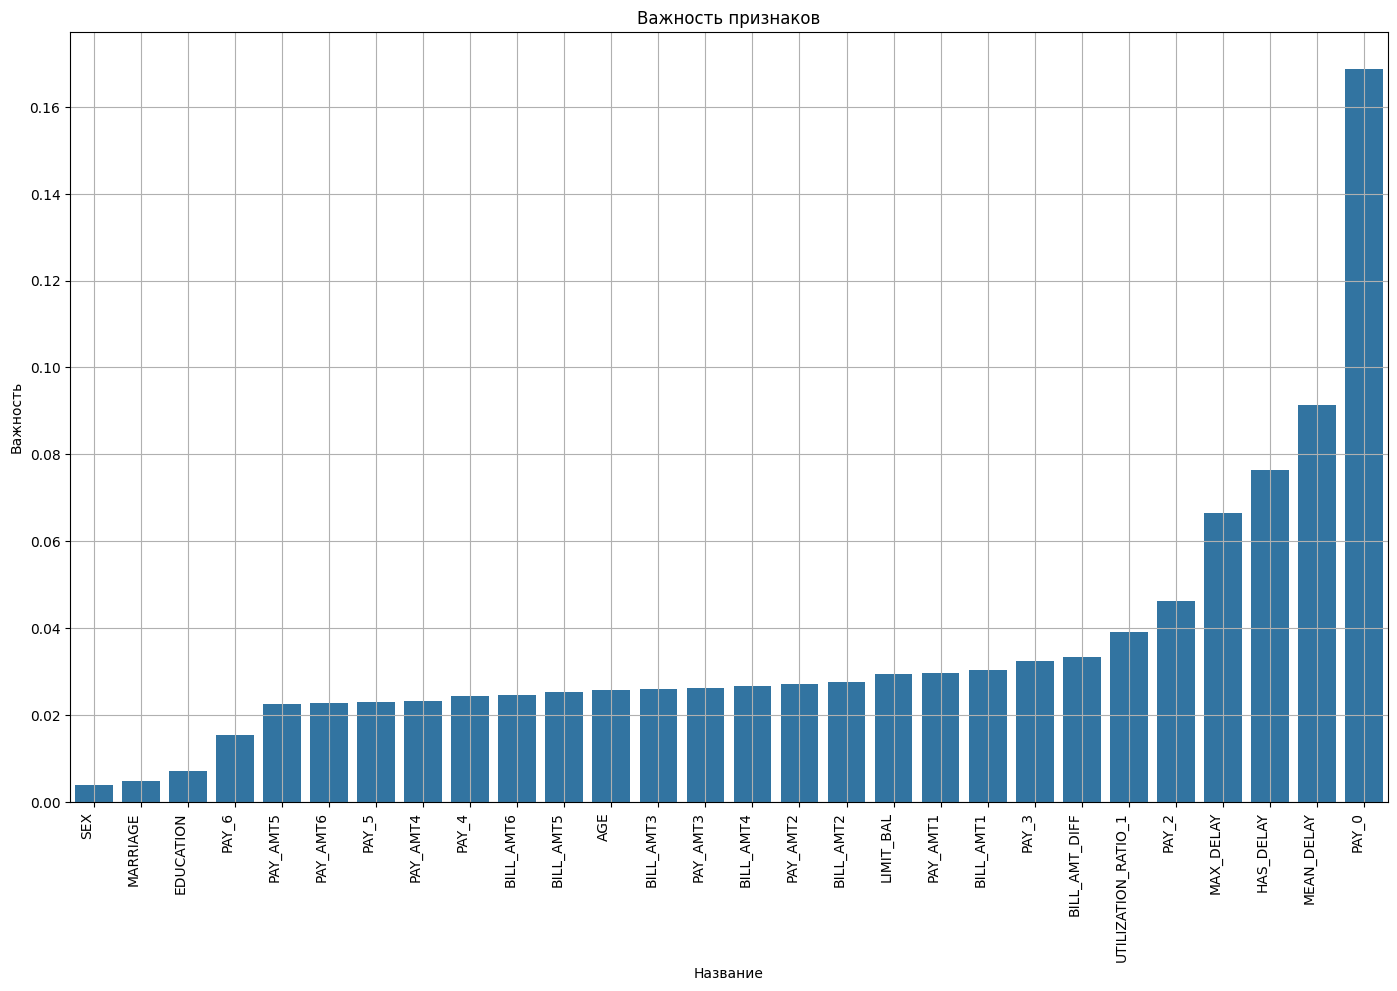

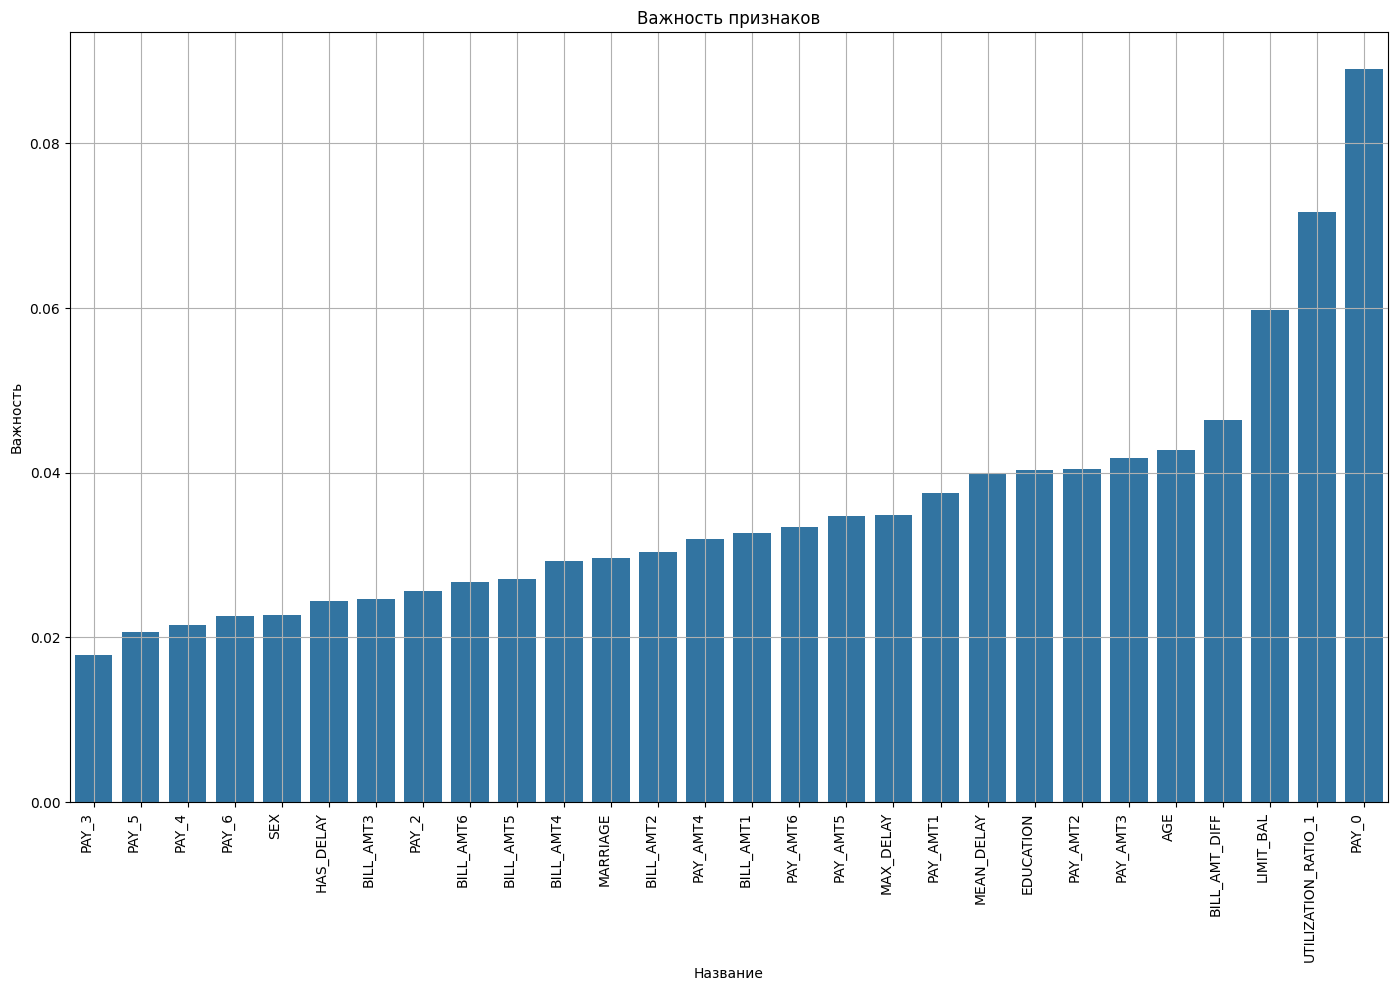

In [489]:
feature_importances_plot(RandForest_2, names)
feature_importances_plot(CatBoost_2, names)

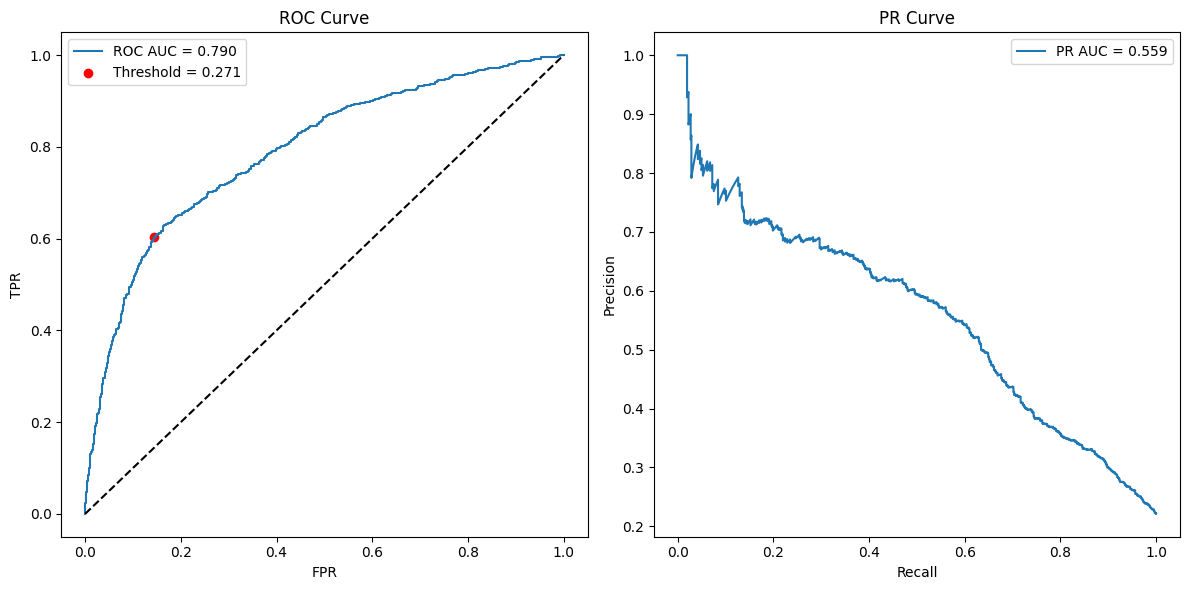

Оптимальный порог: 0.2710


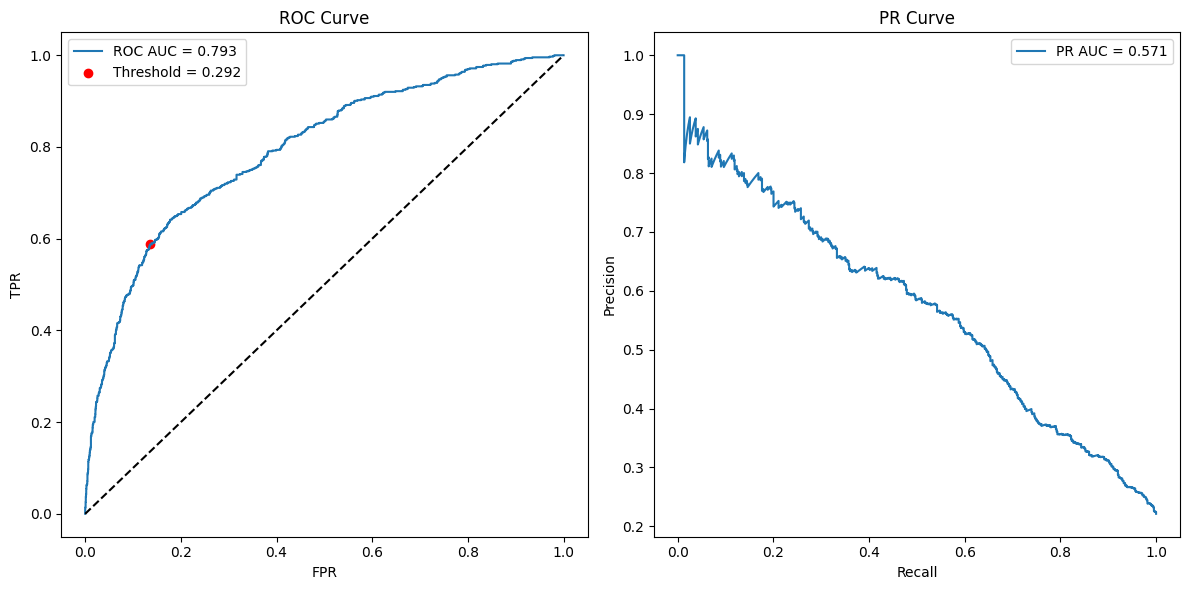

Оптимальный порог: 0.2922


In [490]:
optimal_CatBoost_2 = plot_roc_pr_curves(CatBoost_2, X_val_scaled, y_val)
optimal_RandForest_2 = plot_roc_pr_curves(RandForest_2, X_val_scaled, y_val)

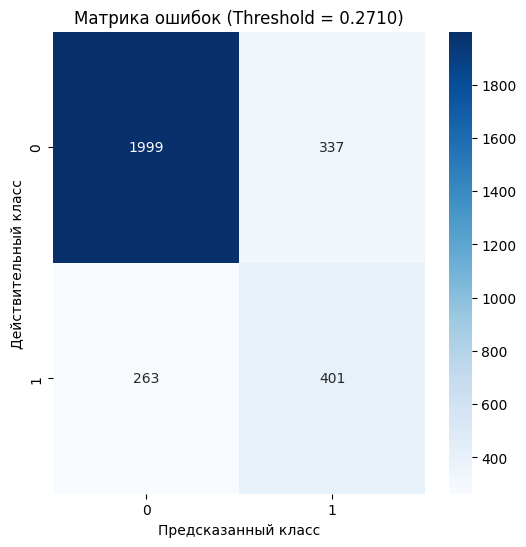


          CatBoost_2 Классификатор - метрики качества
Accuracy            : 0.8000
Balanced Accuracy   : 0.7298
Precision           : 0.5434
Recall              : 0.6039
F1                  : 0.5720
ROC AUC             : 0.7904
PR AUC              : 0.5595
Threshold           : 0.2710


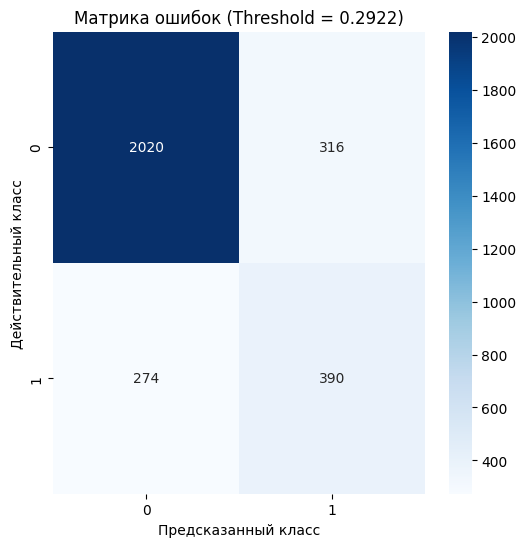


          RandForest_2 Классификатор - метрики качества
Accuracy            : 0.8033
Balanced Accuracy   : 0.7260
Precision           : 0.5524
Recall              : 0.5873
F1                  : 0.5693
ROC AUC             : 0.7930
PR AUC              : 0.5707
Threshold           : 0.2922


In [491]:
metrics_CatBoost_2 = evaluate_classifier(CatBoost_2, X_val_scaled, y_val, model_name = 'CatBoost_2 Классификатор', threshold = optimal_CatBoost_2)
metrics_RandForest_2 = evaluate_classifier(RandForest_2, X_val_scaled, y_val, model_name = 'RandForest_2 Классификатор', threshold = optimal_RandForest_2)

In [492]:
СompareDF = add_metrics_to_df('CatBoost_2', metrics_CatBoost_2, СompareDF)
СompareDF = add_metrics_to_df('RandForest_2', metrics_RandForest_2, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall  \
0                 NB  0.769667           0.711426   0.483794  0.606928   
1             NB_pca  0.772000           0.692983   0.486702  0.551205   
2              KNN_0  0.733000           0.666862   0.420809  0.548193   
3          KNN_pca_0  0.721667           0.659584   0.404894  0.548193   
4              KNN_1  0.787000           0.697225   0.518195  0.536145   
5          KNN_pca_1  0.794000           0.697408   0.535385  0.524096   
6              SVM_0  0.808000           0.690767   0.580000  0.480422   
7          SVM_pca_0  0.806000           0.694873   0.571181  0.495482   
8              SVM_1  0.805333           0.698218   0.567568  0.506024   
9          SVM_pca_1  0.794000           0.703336   0.534226  0.540663   
10          LogReg_0  0.803667           0.698225   0.562396  0.509036   
11      LogReg_pca_0  0.801667           0.689395   0.559585  0.487952   
12          LogReg_1  0.803667           0.698225   0.562396  0.509036   
13      LogReg_pca_1  0.801667           0.689395   0.559585  0.487952   
14      RandForest_0  0.788333           0.717484   0.519205  0.590361   
15  RandForest_pca_0  0.767000           0.711870   0.479388  0.612952   
16      RandForest_1  0.798000           0.722074   0.540278  0.585843   
17  RandForest_pca_1  0.796667           0.716367   0.538244  0.572289   
18        CatBoost_0  0.795000           0.719609   0.533700  0.584337   
19    CatBoost_pca_0  0.769000           0.721778   0.483429  0.637048   
20        CatBoost_1  0.802333           0.728629   0.549237  0.596386   
21    CatBoost_pca_1  0.780667           0.713100   0.503846  0.591867   
22        CatBoost_2  0.800000           0.729826   0.543360  0.603916   
23      RandForest_2  0.803333           0.726038   0.552408  0.587349   

          F1   ROC AUC    PR AUC  Threshold  
0   0.538410  0.738629  0.485081   0.622346  
1   0.516949  0.719346  0.460381   0.562912  
2   0.476128  0.709754  0.416125   0.400000  
3   0.465771  0.701229  0.401991   0.400000  
4   0.527017  0.746651  0.502086   0.266667  
5   0.529680  0.754495  0.493477   0.303050  
6   0.525535  0.732955  0.514870   0.189060  
7   0.530645  0.728542  0.494067   0.196265  
8   0.535032  0.729463  0.513233   0.192587  
9   0.537425  0.729168  0.494315   0.188591  
10  0.534387  0.730489  0.495473   0.295051  
11  0.521319  0.727109  0.473708   0.287607  
12  0.534387  0.730602  0.495685   0.294852  
13  0.521319  0.727107  0.473639   0.287617  
14  0.552502  0.777507  0.542008   0.310000  
15  0.538004  0.751931  0.500927   0.280000  
16  0.562139  0.789232  0.564241   0.278669  
17  0.554745  0.769017  0.516585   0.280266  
18  0.557872  0.785938  0.550557   0.285353  
19  0.549708  0.772662  0.514017   0.229117  
20  0.571841  0.792731  0.559098   0.282588  
21  0.544321  0.775689  0.525227   0.247099  
22  0.572040  0.790371  0.559482   0.270968  
23  0.569343  0.792997  0.570741   0.292241

In [493]:
class MyStacking:
    def __init__(self, base_models, meta_model=None):
        self.base_models = base_models
        self.meta_model = meta_model or LogisticRegression(solver='saga')
        self.scalers = {} 

    def fit(self, X, y, for_params=None, scale=False):
        meta_features = np.zeros((X.shape[0], len(self.base_models)))
        self.scalers = {}

        for i, model in enumerate(self.base_models):
            oof_preds = np.zeros(X.shape[0])
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            for train_idx, val_idx in skf.split(X, y):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train = y.iloc[train_idx]

                model.fit(X_train, y_train)
                oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]

            if scale:
                scaler = StandardScaler()
                oof_preds = scaler.fit_transform(oof_preds.reshape(-1, 1)).ravel()
                self.scalers[i] = scaler

            meta_features[:, i] = oof_preds

        meta_df = pd.DataFrame(meta_features, columns=[f'Model_{i}' for i in range(len(self.base_models))])
        if for_params:
            params = find_best_params(LogisticRegression(solver='saga'), meta_df, y, for_params, 'Params/Stacking_params.json')
            self.meta_model = LogisticRegression(solver='saga', **params)

        self.meta_model.fit(meta_df, y)

    def predict_proba(self, X):
        meta_features = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            preds = model.predict_proba(X)[:, 1]
            if i in self.scalers:
                preds = self.scalers[i].transform(preds.reshape(-1, 1)).ravel()

            meta_features[:, i] = preds

        meta_df = pd.DataFrame(meta_features, columns=[f'Model_{i}' for i in range(len(self.base_models))])
        return self.meta_model.predict_proba(meta_df)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X)[:, 1] >= threshold).astype(int)

In [494]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'],
              'C': np.logspace(-3, 3, 7),
              'max_iter': np.arange(50, 250, 50),
              'tol': np.logspace(-6, -4, 3),
              'l1_ratio': [0.1, 0.5, 0.9]}

In [495]:
Stacking = MyStacking([CatBoostClassifier(**CatBoost_2_params, random_seed=42), 
                       RandomForestClassifier(**RandForest_2_params, random_state=42)])

Stacking.fit(X_train_scaled, y_train, parameters)

0:	learn: 0.6871839	total: 18.2ms	remaining: 7.27s
1:	learn: 0.6812282	total: 34.9ms	remaining: 6.95s
2:	learn: 0.6754678	total: 50.5ms	remaining: 6.68s
3:	learn: 0.6697730	total: 66.7ms	remaining: 6.6s
4:	learn: 0.6643174	total: 84.4ms	remaining: 6.67s
5:	learn: 0.6587184	total: 101ms	remaining: 6.62s
6:	learn: 0.6533278	total: 116ms	remaining: 6.54s
7:	learn: 0.6488191	total: 128ms	remaining: 6.29s
8:	learn: 0.6437353	total: 143ms	remaining: 6.22s
9:	learn: 0.6386699	total: 158ms	remaining: 6.16s
10:	learn: 0.6342042	total: 170ms	remaining: 6s
11:	learn: 0.6295759	total: 184ms	remaining: 5.96s
12:	learn: 0.6249982	total: 200ms	remaining: 5.95s
13:	learn: 0.6202086	total: 215ms	remaining: 5.92s
14:	learn: 0.6156753	total: 230ms	remaining: 5.91s
15:	learn: 0.6113166	total: 250ms	remaining: 6s
16:	learn: 0.6071642	total: 265ms	remaining: 5.98s
17:	learn: 0.6031270	total: 279ms	remaining: 5.93s
18:	learn: 0.5991292	total: 294ms	remaining: 5.9s
19:	learn: 0.5952465	total: 310ms	remaining:

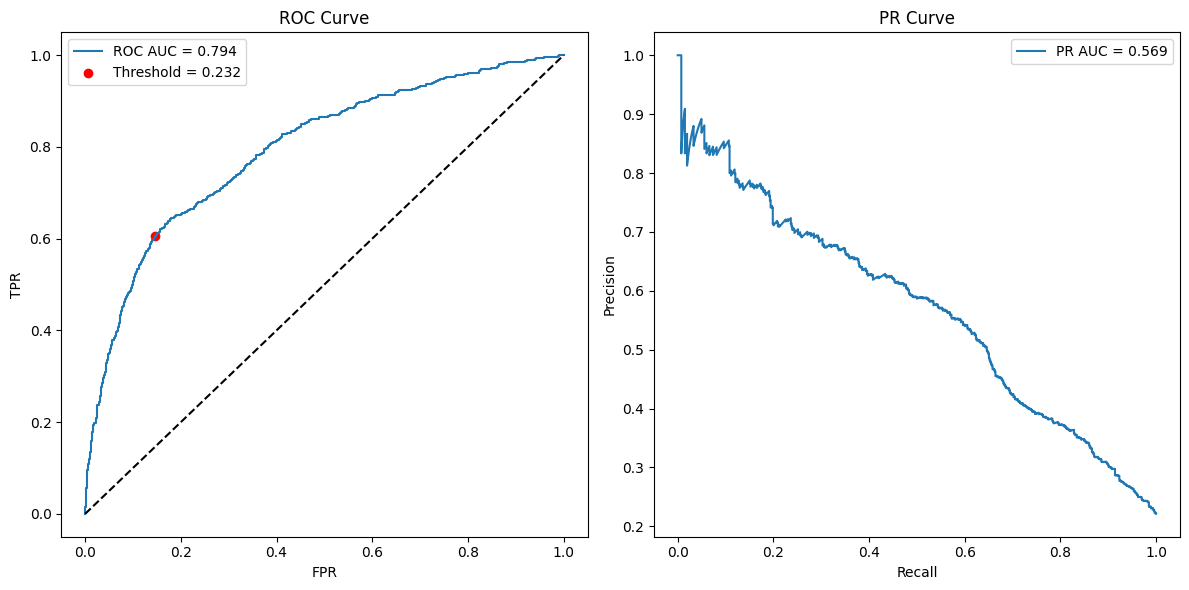

Оптимальный порог: 0.2325


In [496]:
optimal_Stacking = plot_roc_pr_curves(Stacking, X_val_scaled, y_val)

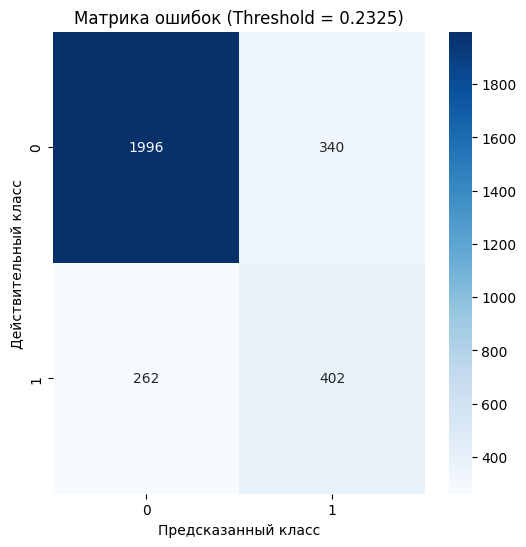


          Stacking Классификатор - метрики качества
Accuracy            : 0.7993
Balanced Accuracy   : 0.7299
Precision           : 0.5418
Recall              : 0.6054
F1                  : 0.5718
ROC AUC             : 0.7938
PR AUC              : 0.5688
Threshold           : 0.2325


In [497]:
metrics_Stacking = evaluate_classifier(Stacking, X_val_scaled, y_val, model_name = 'Stacking Классификатор', threshold = optimal_Stacking)

In [499]:
СompareDF = add_metrics_to_df('Stacking', metrics_Stacking, СompareDF)
СompareDF

Model  Accuracy  Balanced Accuracy  Precision    Recall  \
0                 NB  0.769667           0.711426   0.483794  0.606928   
1             NB_pca  0.772000           0.692983   0.486702  0.551205   
2              KNN_0  0.733000           0.666862   0.420809  0.548193   
3          KNN_pca_0  0.721667           0.659584   0.404894  0.548193   
4              KNN_1  0.787000           0.697225   0.518195  0.536145   
5          KNN_pca_1  0.794000           0.697408   0.535385  0.524096   
6              SVM_0  0.808000           0.690767   0.580000  0.480422   
7          SVM_pca_0  0.806000           0.694873   0.571181  0.495482   
8              SVM_1  0.805333           0.698218   0.567568  0.506024   
9          SVM_pca_1  0.794000           0.703336   0.534226  0.540663   
10          LogReg_0  0.803667           0.698225   0.562396  0.509036   
11      LogReg_pca_0  0.801667           0.689395   0.559585  0.487952   
12          LogReg_1  0.803667           0.698225   0.562396  0.509036   
13      LogReg_pca_1  0.801667           0.689395   0.559585  0.487952   
14      RandForest_0  0.788333           0.717484   0.519205  0.590361   
15  RandForest_pca_0  0.767000           0.711870   0.479388  0.612952   
16      RandForest_1  0.798000           0.722074   0.540278  0.585843   
17  RandForest_pca_1  0.796667           0.716367   0.538244  0.572289   
18        CatBoost_0  0.795000           0.719609   0.533700  0.584337   
19    CatBoost_pca_0  0.769000           0.721778   0.483429  0.637048   
20        CatBoost_1  0.802333           0.728629   0.549237  0.596386   
21    CatBoost_pca_1  0.780667           0.713100   0.503846  0.591867   
22        CatBoost_2  0.800000           0.729826   0.543360  0.603916   
23      RandForest_2  0.803333           0.726038   0.552408  0.587349   
24          Stacking  0.799333           0.729937   0.541779  0.605422   

          F1   ROC AUC    PR AUC  Threshold  
0   0.538410  0.738629  0.485081   0.622346  
1   0.516949  0.719346  0.460381   0.562912  
2   0.476128  0.709754  0.416125   0.400000  
3   0.465771  0.701229  0.401991   0.400000  
4   0.527017  0.746651  0.502086   0.266667  
5   0.529680  0.754495  0.493477   0.303050  
6   0.525535  0.732955  0.514870   0.189060  
7   0.530645  0.728542  0.494067   0.196265  
8   0.535032  0.729463  0.513233   0.192587  
9   0.537425  0.729168  0.494315   0.188591  
10  0.534387  0.730489  0.495473   0.295051  
11  0.521319  0.727109  0.473708   0.287607  
12  0.534387  0.730602  0.495685   0.294852  
13  0.521319  0.727107  0.473639   0.287617  
14  0.552502  0.777507  0.542008   0.310000  
15  0.538004  0.751931  0.500927   0.280000  
16  0.562139  0.789232  0.564241   0.278669  
17  0.554745  0.769017  0.516585   0.280266  
18  0.557872  0.785938  0.550557   0.285353  
19  0.549708  0.772662  0.514017   0.229117  
20  0.571841  0.792731  0.559098   0.282588  
21  0.544321  0.775689  0.525227   0.247099  
22  0.572040  0.790371  0.559482   0.270968  
23  0.569343  0.792997  0.570741   0.292241  
24  0.571835  0.793833  0.568788   0.232452

In [500]:
find_best_models(СompareDF)

Best Model     Value
Accuracy                    SVM_0  0.808000
Balanced Accuracy        Stacking  0.729937
Precision                   SVM_0  0.580000
Recall             CatBoost_pca_0  0.637048
F1                     CatBoost_2  0.572040
ROC AUC                  Stacking  0.793833
PR AUC               RandForest_2  0.570741

# 10. Тест

## Посмотрим стекинг модель на Test датасете. При этом используем Threshold, который получили на валидации.

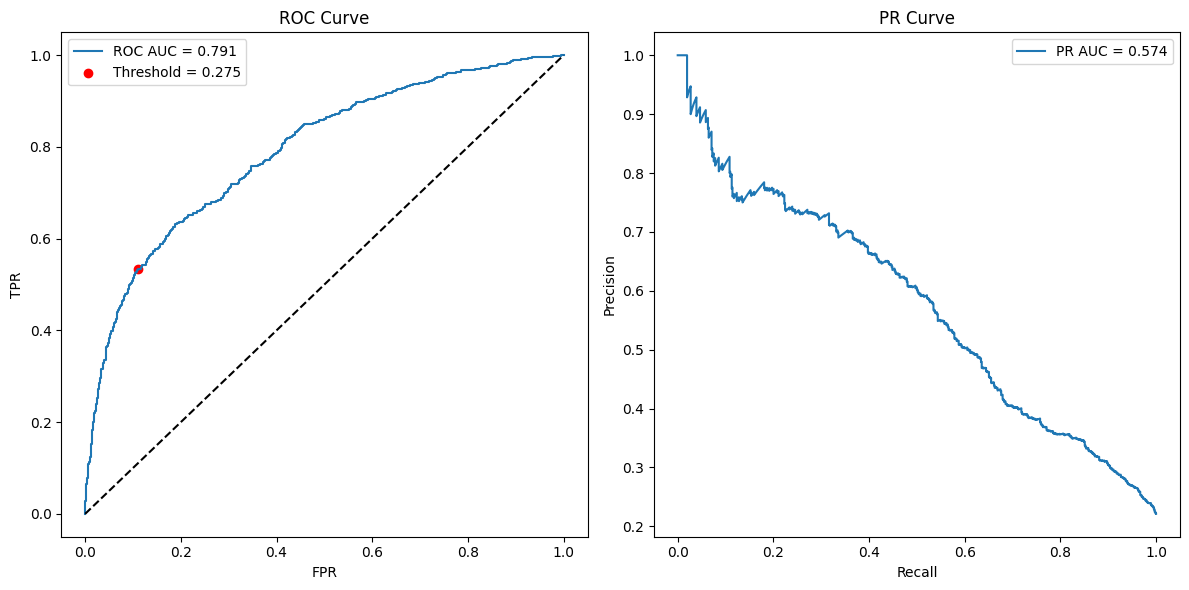

Оптимальный порог: 0.2750


np.float64(0.27496470958444735)

In [501]:
plot_roc_pr_curves(Stacking, X_test_scaled, y_test)

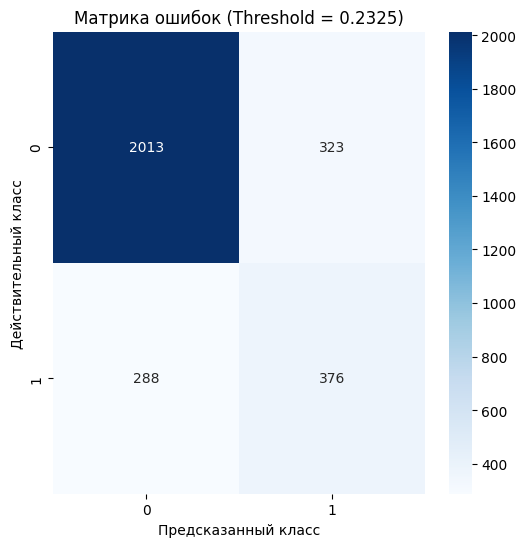


          Stacking Классификатор (тест) - метрики качества
Accuracy            : 0.7963
Balanced Accuracy   : 0.7140
Precision           : 0.5379
Recall              : 0.5663
F1                  : 0.5517
ROC AUC             : 0.7908
PR AUC              : 0.5741
Threshold           : 0.2325


In [502]:
metrics_Stacking_test = evaluate_classifier(Stacking, X_test_scaled, y_test, model_name = 'Stacking Классификатор (тест)', threshold = optimal_Stacking)